<a href="https://colab.research.google.com/github/JSluo888/Interpretability/blob/main/scBasset_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [ ]:
import os
## Change it to the GPU you are using
os.environ['CUDA_VISIBLE_DEVICES']='1'

import random, sys, pysam, anndata, h5py, psutil, math, pickle, scipy, configparser,gc, time, logomaker
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from datetime import datetime
import pandas as pd
from Bio import SeqIO
from scipy import sparse
from tqdm import tqdm
import igraph as ig
import leidenalg as la
from leiden_clustering import LeidenClustering
import wandb as wb
from wandb.keras import WandbCallback
import umap.umap_ as umap
import umap.plot as umap_plot



# Load Dataset (Need to do before loading the model!!)

In [ ]:
filepath = '/home/tianhao/thymus/thymus1.h5'
with h5py.File(filepath, 'r') as dataset:
    x_train = np.array(dataset['X_train']).astype(np.float32)
    y_train = np.array(dataset['Y_train']).astype(np.float32)
    x_valid = np.array(dataset['X_valid']).astype(np.float32)
    y_valid = np.array(dataset['Y_valid']).astype(np.int32)
    x_test = np.array(dataset['X_test']).astype(np.float32)
    y_test = np.array(dataset['Y_test']).astype(np.int32)

# Data Augmentation from scBasset

In [ ]:
class StochasticReverseComplement(tf.keras.layers.Layer):
    """Stochastically reverse complement a one hot encoded DNA sequence."""

    def __init__(self, **kwargs):
        super(StochasticReverseComplement, self).__init__()

    def call(self, seq_1hot, training=None):
        if training:
            rc_seq_1hot = tf.gather(seq_1hot, [3, 2, 1, 0], axis=-1)
            rc_seq_1hot = tf.reverse(rc_seq_1hot, axis=[1])
            reverse_bool = tf.random.uniform(shape=[]) > 0.5
            src_seq_1hot = tf.cond(reverse_bool, lambda: rc_seq_1hot, lambda: seq_1hot)
            return src_seq_1hot, reverse_bool
        else:
            return seq_1hot, tf.constant(False)


class SwitchReverse(tf.keras.layers.Layer):
    """Reverse predictions if the inputs were reverse complemented."""

    def __init__(self, **kwargs):
        super(SwitchReverse, self).__init__()

    def call(self, x_reverse):
        x = x_reverse[0]
        reverse = x_reverse[1]

        xd = len(x.shape)
        if xd == 3:
            rev_axes = [1]
        elif xd == 4:
            rev_axes = [1, 2]
        else:
            raise ValueError("Cannot recognize SwitchReverse input dimensions %d." % xd)

        return tf.keras.backend.switch(reverse, tf.reverse(x, axis=rev_axes), x)


class StochasticShift(tf.keras.layers.Layer):
    """Stochastically shift a one hot encoded DNA sequence."""

    def __init__(self, shift_max=0, pad="uniform", **kwargs):
        super(StochasticShift, self).__init__()
        self.shift_max = shift_max
        self.augment_shifts = tf.range(-self.shift_max, self.shift_max + 1)
        self.pad = pad

    def call(self, seq_1hot, training=None):
        if training:
            shift_i = tf.random.uniform(
                shape=[], minval=0, dtype=tf.int64, maxval=len(self.augment_shifts)
            )
            shift = tf.gather(self.augment_shifts, shift_i)
            sseq_1hot = tf.cond(
                tf.not_equal(shift, 0),
                lambda: shift_sequence(seq_1hot, shift),
                lambda: seq_1hot,
            )
            return sseq_1hot
        else:
            return seq_1hot

    def get_config(self):
        config = super().get_config().copy()
        config.update({"shift_max": self.shift_max, "pad": self.pad})
        return config

def shift_sequence(seq, shift, pad_value=0.25):
    """Shift a sequence left or right by shift_amount.

    Args:
    seq: [batch_size, seq_length, seq_depth] sequence
    shift: signed shift value (tf.int32 or int)
    pad_value: value to fill the padding (primitive or scalar tf.Tensor)
    """
    if seq.shape.ndims != 3:
        raise ValueError("input sequence should be rank 3")
    input_shape = seq.shape

    pad = pad_value * tf.ones_like(seq[:, 0 : tf.abs(shift), :])

    def _shift_right(_seq):
        # shift is positive
        sliced_seq = _seq[:, :-shift:, :]
        return tf.concat([pad, sliced_seq], axis=1)

    def _shift_left(_seq):
        # shift is negative
        sliced_seq = _seq[:, -shift:, :]
        return tf.concat([sliced_seq, pad], axis=1)

    sseq = tf.cond(
        tf.greater(shift, 0), lambda: _shift_right(seq), lambda: _shift_left(seq)
    )
    sseq.set_shape(input_shape)

    return sseq

def get_cell_embedding(model, bc_model=False):
    """get cell embeddings from trained model"""
    if bc_model:
         output = model.layers[-6].get_weights()[0].transpose()
    else:
         output = model.layers[-3].get_weights()[0].transpose()
    return output



# Saliency Map/Explainer

In [ ]:
def function_batch(X, fun, batch_size=128, **kwargs):
  """ run a function in batches """

  dataset = tf.data.Dataset.from_tensor_slices(X)
  outputs = []
  for x in dataset.batch(batch_size):
    outputs.append(fun(x, **kwargs))
  return np.concatenate(outputs, axis=0)


@tf.function
def saliency_map(X, model, class_index=None, func=tf.math.reduce_mean):
  """fast function to generate saliency maps"""
  if not tf.is_tensor(X):
    X = tf.Variable(X)

  with tf.GradientTape() as tape:
    tape.watch(X)
    if class_index is not None:
      outputs = model(X)[:, class_index]
    else:
      outputs = func(model(X))
  return tape.gradient(outputs, X)



def smoothgrad(x, model, num_samples=50, mean=0.0, stddev=0.1,
               class_index=None, func=tf.math.reduce_mean):

  _,L,A = x.shape
  x_noise = tf.tile(x, (num_samples,1,1)) + tf.random.normal((num_samples,L,A), mean, stddev)
  grad = saliency_map(x_noise, model, class_index=class_index, func=func)
  return tf.reduce_mean(grad, axis=0, keepdims=True)




def integrated_grad(x, model, baseline, num_steps=25,
                         class_index=None, func=tf.math.reduce_mean):

  def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

  def interpolate_data(baseline, x, steps):
    steps_x = steps[:, tf.newaxis, tf.newaxis]
    delta = x - baseline
    x = baseline +  steps_x * delta
    return x

  steps = tf.linspace(start=0.0, stop=1.0, num=num_steps+1)
  x_interp = interpolate_data(baseline, x, steps)
  grad = saliency_map(x_interp, model, class_index=class_index, func=func)
  avg_grad = integral_approximation(grad)
  avg_grad= np.expand_dims(avg_grad, axis=0)
  return avg_grad


class Explainer():
  """wrapper class for attribution maps"""

  def __init__(self, model, class_index=None, func=tf.math.reduce_mean):

    self.model = model
    self.class_index = class_index
    self.func = func

  def saliency(self, X, batch_size=128):

    return function_batch(X, saliency_map, batch_size, model=self.model,
                          class_index=self.class_index, func=self.func)

  def smoothgrad(self, X, num_samples=50, mean=0.0, stddev=0.1):

    return function_batch(X, smoothgrad, batch_size=1, model=self.model,
                           num_samples=num_samples, mean=mean, stddev=stddev,
                           class_index=self.class_index, func=self.func)

  def intgrad(self, X, baseline_type='random', num_steps=25):
    scores = []
    for x in X:
      x = np.expand_dims(x, axis=0)
      baseline = self.set_baseline(x, baseline_type, num_samples=1)
      intgrad_scores = integrated_grad(x, model=self.model, baseline=baseline,
                           num_steps=num_steps, class_index=self.class_index, func=self.func)
      scores.append(intgrad_scores)
    return np.concatenate(scores, axis=0)

  def set_baseline(self, x, baseline, num_samples):
    if baseline == 'random':
      baseline = random_shuffle(x, num_samples)
    else:
      baseline = np.zeros((x.shape))
    return baseline


#------------------------------------------------------------------------------
# Useful functions
#------------------------------------------------------------------------------


def grad_times_input(x, scores):
  new_scores = []
  for i, score in enumerate(scores):
    new_scores.append(np.sum(x[i]*score, axis=1))
  return np.array(new_scores)


def grad_correction(x):
  return x - np.mean(x, axis=2, keepdims=True)


def function_batch(X, fun, batch_size=128, **kwargs):
  """ run a function in batches """

  dataset = tf.data.Dataset.from_tensor_slices(X)
  outputs = []
  for x in dataset.batch(batch_size):
    outputs.append(fun(x, **kwargs))
  return np.concatenate(outputs, axis=0)

def random_shuffle(x, num_samples=1):
  """ randomly shuffle sequences
      assumes x shape is (N,L,A) """

  x_shuffle = []
  for i in range(num_samples):
    shuffle = np.random.permutation(x.shape[1])
    x_shuffle.append(x[0,shuffle,:])
  return np.array(x_shuffle)


def plot_attribution_map(saliency_df, ax=None, figsize=(20,1)):
  """plot an attribution map using logomaker"""

  logomaker.Logo(saliency_df, figsize=figsize, ax=ax)
  if ax is None:
    ax = plt.gca()
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.yaxis.set_ticks_position('none')
  ax.xaxis.set_ticks_position('none')
  plt.xticks([])
  plt.yticks([])

def prob_to_info_df(w, alphabet='ACGT'):

  # Calculate sequence logo heights -- information
  I = np.log2(4) + np.sum(w * np.log2(w+1e-7), axis=1, keepdims=True)
  logo = I*w

  L, A = logo.shape
  counts_df = pd.DataFrame(data=0.0, columns=list(alphabet), index=list(range(L)))
  for a in range(A):
      for l in range(L):
          counts_df.iloc[l,a] = logo[l,a]
  return counts_df


def grad_times_input_to_df(x, grad, alphabet='ACGT'):
  """generate pandas dataframe for saliency plot
     based on grad x inputs """

  x_index = np.argmax(np.squeeze(x), axis=1)
  grad = np.squeeze(grad)
  L, A = grad.shape

  seq = ''
  saliency = np.zeros((L))
  for i in range(L):
    seq += alphabet[x_index[i]]
    saliency[i] = grad[i,x_index[i]]

  # create saliency matrix
  saliency_df = logomaker.saliency_to_matrix(seq=seq, values=saliency)
  return saliency_df


# Original scBasset (GeLU, no bacth correction)

In [ ]:
##############
# activation #
##############
class GELU(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(GELU, self).__init__(**kwargs)

    def call(self, x):
        # return tf.keras.activations.sigmoid(1.702 * x) * x. GELU approximation
        return tf.keras.activations.sigmoid(tf.constant(1.702) * x) * x

def base_relu(input_shape):
    inputs = tf.keras.Input(shape=input_shape, name='sequence')

    (nn, reverse_bool,) = StochasticReverseComplement()(inputs)
    nn=StochasticShift(3)(nn)

    #Conv Block
    nn=GELU()(nn)
    nn=tf.keras.layers.Conv1D(filters=288,
                           kernel_size=17,
                           strides=1,
                           padding='same',
                           use_bias=False,
                           dilation_rate=1,
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0),)(nn)
    nn=tf.keras.layers.BatchNormalization(momentum=0.90,gamma_initializer='ones')(nn)
    nn=tf.keras.layers.MaxPool1D(pool_size=3, padding='same')(nn)

    #Conv Tower
    def _round(x):
        return int(np.round(x / 1) * 1)
    rep_filters = 288
    for i in range(6):
        nn=GELU()(nn)
        nn=tf.keras.layers.Conv1D(filters=_round(rep_filters),
                           kernel_size=5,
                           strides=1,
                           padding='same',
                           use_bias=False,
                           dilation_rate=1,
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0),)(nn)
        nn=tf.keras.layers.BatchNormalization(momentum=0.90,gamma_initializer='ones')(nn)
        nn=tf.keras.layers.MaxPool1D(pool_size=2, padding='same')(nn)
        rep_filters*=1.122

    #Conv Block
    nn=GELU()(nn)
    nn=tf.keras.layers.Conv1D(filters=256,
                           kernel_size=1,
                           strides=1,
                           padding='same',
                           use_bias=False,
                           dilation_rate=1,
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0),)(nn)
    nn=tf.keras.layers.BatchNormalization(momentum=0.90,gamma_initializer='ones')(nn)

    #Dense
    nn=GELU()(nn)
    _, seq_len, seq_depth = nn.shape
    nn = tf.keras.layers.Reshape((1, seq_len * seq_depth,))(nn)
    nn = tf.keras.layers.Dense(units=32, use_bias=False, kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.l1_l2(0,0),)(nn)
    nn=tf.keras.layers.BatchNormalization(momentum=0.90,gamma_initializer='ones')(nn)
    nn = tf.keras.layers.Dropout(rate=0.2)(nn)

    nn=GELU()(nn)

    #Final
    nn=tf.keras.layers.Dense(units=y_train.shape[-1], use_bias=True, activation='sigmoid',
                          kernel_initializer="he_normal",kernel_regularizer=tf.keras.regularizers.l1_l2(0,0))(nn)

    #Swtich back
    nn=SwitchReverse()([nn, reverse_bool])

    nn=tf.keras.layers.Flatten()(nn)
    model = tf.keras.Model(inputs=inputs, outputs=nn)

    return model


# scBasset with Exponential Activation, no batch correction

In [ ]:
##############
# activation #
##############
class GELU(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(GELU, self).__init__(**kwargs)

    def call(self, x):
        # return tf.keras.activations.sigmoid(1.702 * x) * x. GELU approximation
        return tf.keras.activations.sigmoid(tf.constant(1.702) * x) * x


def base_exp(input_shape):
    inputs = tf.keras.Input(shape=input_shape, name='sequence')

    (nn, reverse_bool,) = StochasticReverseComplement()(inputs)
    nn=StochasticShift(3)(nn)

    #Conv Block
    nn=GELU()(nn)
    nn=tf.keras.layers.Conv1D(filters=288,
                           kernel_size=17,
                           strides=1,
                           padding='same',
                           use_bias=False,
                           dilation_rate=1,
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0),)(nn)
    nn=tf.keras.layers.BatchNormalization(momentum=0.90,gamma_initializer='ones')(nn)

    nn = tf.keras.layers.Activation('exponential', name='conv_activation')(nn)

    nn=tf.keras.layers.MaxPool1D(pool_size=3, padding='same')(nn)

    #Conv Tower
    def _round(x):
        return int(np.round(x / 1) * 1)
    rep_filters = 288
    for i in range(6):
        if i != 0:
            nn=GELU()(nn)
        nn=tf.keras.layers.Conv1D(filters=_round(rep_filters),
                           kernel_size=5,
                           strides=1,
                           padding='same',
                           use_bias=False,
                           dilation_rate=1,
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0),)(nn)
        nn=tf.keras.layers.BatchNormalization(momentum=0.90,gamma_initializer='ones')(nn)
        nn=tf.keras.layers.MaxPool1D(pool_size=2, padding='same')(nn)
        rep_filters*=1.122

    #Conv Block
    nn=GELU()(nn)
    nn=tf.keras.layers.Conv1D(filters=256,
                           kernel_size=1,
                           strides=1,
                           padding='same',
                           use_bias=False,
                           dilation_rate=1,
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0),)(nn)
    nn=tf.keras.layers.BatchNormalization(momentum=0.90,gamma_initializer='ones')(nn)

    #Dense
    nn=GELU()(nn)
    _, seq_len, seq_depth = nn.shape
    nn = tf.keras.layers.Reshape((1, seq_len * seq_depth,))(nn)
    nn = tf.keras.layers.Dense(units=32, use_bias=False, kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.l1_l2(0,0),)(nn)
    nn=tf.keras.layers.BatchNormalization(momentum=0.90,gamma_initializer='ones')(nn)
    nn = tf.keras.layers.Dropout(rate=0.2)(nn)

    nn=GELU()(nn)

    #Final
    nn=tf.keras.layers.Dense(units=y_train.shape[-1], use_bias=True, activation='sigmoid',
                          kernel_initializer="he_normal",kernel_regularizer=tf.keras.regularizers.l1_l2(0,0))(nn)

    #Swtich back
    nn=SwitchReverse()([nn, reverse_bool])

    nn=tf.keras.layers.Flatten()(nn)
    model = tf.keras.Model(inputs=inputs, outputs=nn)

    return model

# Batch Correction

In [ ]:
##############
# activation #
##############
class GELU(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(GELU, self).__init__(**kwargs)

    def call(self, x):
        # return tf.keras.activations.sigmoid(1.702 * x) * x. GELU approximation
        return tf.keras.activations.sigmoid(tf.constant(1.702) * x) * x

def base_bc_relu(input_shape, batch_m):
    inputs = tf.keras.Input(shape=input_shape, name='sequence')

    (nn, reverse_bool,) = StochasticReverseComplement()(inputs)
    nn=StochasticShift(3)(nn)

    #Conv Block
    nn=GELU()(nn)
    nn=tf.keras.layers.Conv1D(filters=288,
                           kernel_size=17,
                           strides=1,
                           padding='same',
                           use_bias=False,
                           dilation_rate=1,
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0),)(nn)
    nn=tf.keras.layers.BatchNormalization(momentum=0.90,gamma_initializer='ones')(nn)
    nn=tf.keras.layers.MaxPool1D(pool_size=3, padding='same')(nn)

    #Conv Tower
    def _round(x):
        return int(np.round(x / 1) * 1)
    rep_filters = 288
    for i in range(6):
        nn=GELU()(nn)
        nn=tf.keras.layers.Conv1D(filters=_round(rep_filters),
                           kernel_size=5,
                           strides=1,
                           padding='same',
                           use_bias=False,
                           dilation_rate=1,
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0),)(nn)
        nn=tf.keras.layers.BatchNormalization(momentum=0.90,gamma_initializer='ones')(nn)
        nn=tf.keras.layers.MaxPool1D(pool_size=2, padding='same')(nn)
        rep_filters*=1.122

    #Conv Block
    nn=GELU()(nn)
    nn=tf.keras.layers.Conv1D(filters=256,
                           kernel_size=1,
                           strides=1,
                           padding='same',
                           use_bias=False,
                           dilation_rate=1,
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0),)(nn)
    nn=tf.keras.layers.BatchNormalization(momentum=0.90,gamma_initializer='ones')(nn)

    #Dense
    nn=GELU()(nn)
    _, seq_len, seq_depth = nn.shape
    nn = tf.keras.layers.Reshape((1, seq_len * seq_depth,))(nn)
    nn = tf.keras.layers.Dense(units=32, use_bias=False, kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.l1_l2(0,0),)(nn)
    nn=tf.keras.layers.BatchNormalization(momentum=0.90,gamma_initializer='ones')(nn)
    nn = tf.keras.layers.Dropout(rate=0.2)(nn)

    nn=GELU()(nn)

    # BC part, replacing the final layer in non-bc version
    batch_info = tf.constant(batch_m.values.transpose(), dtype='float32') # batch matrix
    current1 = tf.keras.layers.Dense(units=y_train.shape[-1], # path1
                                     kernel_regularizer=tf.keras.regularizers.l2(0))(current)

    current2 = tf.keras.layers.Dense(units=batch_info.shape[0], # path2
                                     kernel_regularizer=tf.keras.regularizers.l2(0))(current)
    current2 = tf.linalg.matmul(current2, batch_info)
    current = tf.math.add(current1, current2) # sum
    current = tf.keras.layers.Activation(activation='sigmoid')(current)

    #Swtich back
    nn=SwitchReverse()([nn, reverse_bool])

    nn=tf.keras.layers.Flatten()(nn)
    model = tf.keras.Model(inputs=inputs, outputs=nn)

    return model


# Train the model (Can skip if you already have a trained model)

In [ ]:
N,L,A = x_train.shape
tf.keras.backend.clear_session()

### Change it to the model you want
model = base_exp(input_shape=(L,A))

# A better initialization
def reinitialize_kernel_weights(model, kernel_initializer):
  # can change initialization after creating model this way!
  for i, layer in enumerate(model.layers):
    if hasattr(layer, 'kernel_initializer'):

      # Get the current configuration of the layer
      weight_initializer = layer.kernel_initializer

      val = layer.get_weights()
      if len(val) > 1:
        old_weights, old_biases = val
        layer.set_weights([kernel_initializer(shape=old_weights.shape), old_biases])
      else:
        old_weights = val[0]
        layer.set_weights([kernel_initializer(shape=old_weights.shape)])

kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.001)  # Replace this with your desired initializer
reinitialize_kernel_weights(model, kernel_initializer)

# compile model
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.95,beta_2=0.9995)
model.compile(loss=loss_fn, optimizer=optimizer,
                  metrics=[tf.keras.metrics.AUC(name='auc', curve='ROC', multi_label=True),
                           tf.keras.metrics.AUC(name='auc_pr', curve='PR', multi_label=True)])

# Note: Login the WandB in the terminal first, which is easy to do by following their website instruction

### Change the project name and run name
wb.init(project='experiment', name='exp_valauc')

### Change the path here to save the best model
out_dir = '/home/tianhao/best_models'
filepath_best = '%s/thymus_exp_valauc_0731.h5'%out_dir
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath_best,
                                       save_best_only=True,
                                       save_weights_only=True,
                                       monitor='val_auc', mode='max',
                                      save_freq='epoch'),
    tf.keras.callbacks.EarlyStopping(monitor='val_auc', min_delta=1e-6,
                                     mode='max', patience=20, verbose=1,restore_best_weights=True),
    WandbCallback(),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc',
                                         factor=0.2, patience=3,
                                         verbose=1, mode='max'),
]

### Change the epochs number if necessary
history = model.fit(
        x_train,
        y_train,
        epochs=200,
        callbacks=callbacks,
        validation_data=(x_valid, y_valid))

# Load the trained model

In [ ]:
### Change the path here
trained_model = '/home/tianhao/best_models/thymus1_exp_valauc_final_5.h5'
N,L,A = x_train.shape
tf.keras.backend.clear_session()
### Change the type of model
model=base_exp((L,A))

# compile model
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.95,beta_2=0.9995)
model.compile(loss=loss_fn, optimizer=optimizer,
                  metrics=[tf.keras.metrics.AUC(name='auc', curve='ROC', multi_label=True),
                           tf.keras.metrics.AUC(name='auc_pr', curve='PR', multi_label=True)])
# load model
model.load_weights(trained_model)

proj = get_cell_embedding(model)
clustering = LeidenClustering()
clustering.fit(proj)
label = clustering.labels_

labeled = np.vstack((y_test, label))
labeled = pd.DataFrame(labeled)

### Can change func to others, like max. Default is mean
explainer_exp = Explainer(model, class_index=0, func=tf.math.reduce_mean)
num = len(np.unique(labeled.iloc[-1]))
row = labeled.shape[0] - 1

# Test set performance

In [ ]:
### Change the path here
trained_model = '/home/tianhao/best_models/thymus1_exp_valauc_final_5.h5'
### Change the type of model
model=base_exp((1344, 4))

# compile model
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.95,beta_2=0.9995)
model.compile(loss=loss_fn, optimizer=optimizer,
                  metrics=[tf.keras.metrics.AUC(name='auc', curve='ROC', multi_label=True),
                           tf.keras.metrics.AUC(name='auc_pr', curve='PR', multi_label=True)])
# load model
model.load_weights(trained_model)
model.evaluate(x_test, y_test)

# UMAP Clustering

719/719 [==============================] - 12s 12ms/step - loss: 0.1758 - auc: 0.8237 - auc_pr: 0.3369


<Axes: >

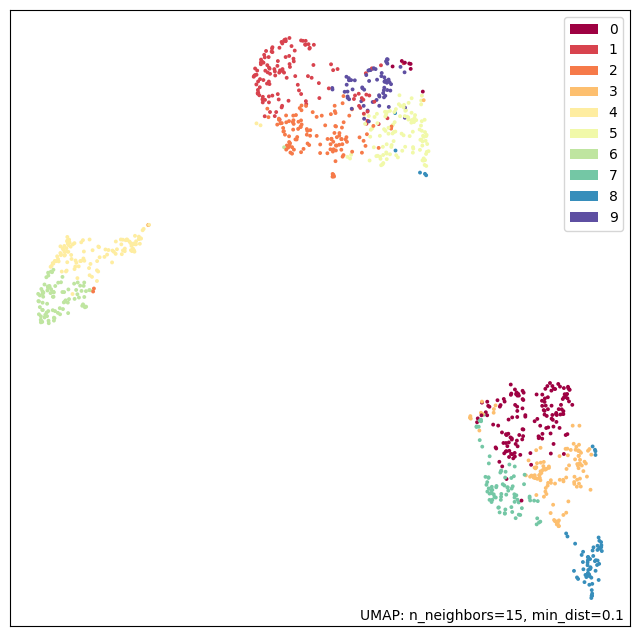

In [ ]:
### Change the path here
trained_model = '/home/tianhao/best_models/thymus1_exp_valauc_final_5.h5'
### Change the type of model
N,L,A = x_train.shape
model=base_exp((L,A))

# compile model
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.95,beta_2=0.9995)
model.compile(loss=loss_fn, optimizer=optimizer,
                  metrics=[tf.keras.metrics.AUC(name='auc', curve='ROC', multi_label=True),
                           tf.keras.metrics.AUC(name='auc_pr', curve='PR', multi_label=True)])
# load model
model.load_weights(trained_model)
model.evaluate(x_test, y_test)
proj = get_cell_embedding(model)
clustering = LeidenClustering()
clustering.fit(proj)
label = clustering.labels_

mapper=umap.UMAP().fit(proj)
umap_plot.points(mapper, labels=label)

# First Layer Filters

In [ ]:
def filter_max_align_batch(X, model, layer=3, window=24, threshold=0.5, batch_size=1024, max_align=1e4, verbose=1):
  """get alignment of filter activations for visualization"""
  if verbose:
    print("Calculating filter PPM based on activation-based alignments")

  N,L,A = X.shape
  num_filters = model.layers[layer].output.shape[2]

  # Set the left and right window sizes
  window_left = int(window/2)
  window_right = window - window_left

  # get feature maps of 1st convolutional layer after activation
  intermediate = keras.Model(inputs=model.inputs, outputs=model.layers[layer].output)

  # batch the data
  dataset = tf.data.Dataset.from_tensor_slices(X)
  batches = dataset.batch(batch_size)

  # loop over batches to capture MAX activation
  if verbose:
    print('  Calculating MAX activation')
  MAX = np.zeros(num_filters)
  for x in batches:

    # get feature map for mini-batch
    fmap = intermediate.predict(x, verbose=0)

    # loop over each filter to find "active" positions
    for f in range(num_filters):
      MAX[f] = np.maximum(MAX[f], np.max(fmap[:,:,f]))


  # loop over each filter to find "active" positions
  W = []
  counts = []
  for f in tqdm(range(num_filters)):
    if verbose:
      print("    processing %d out of %d filters"%(f+1, num_filters))
    status = 0

    # compile sub-model to get feature map
    intermediate = keras.Model(inputs=model.inputs, outputs=model.layers[layer].output[:,:,f])

    # loop over each batch
    #dataset = tf.data.Dataset.from_tensor_slices(X)
    seq_align_sum = np.zeros((window, A)) # running sum
    counter = 0                            # counts the number of sequences in alignment
    status = 1                            # monitors whether depth of alignment has reached max_align
    for x in batches:
      if status:

        # get feature map for a batch sequences
        fmaps = intermediate.predict(x, verbose=0)

        # Find regions above threshold
        for data_index, fmap in enumerate(fmaps):
          if status:
            pos_index = np.where(fmap > MAX[f] * threshold)[0]

            # Make a sequence alignment centered about each activation (above threshold)
            for i in range(len(pos_index)):
              if status:
                # Determine position of window about each filter activation
                start_window = pos_index[i] - window_left
                end_window = pos_index[i] + window_right

                # Check to make sure positions are valid
                if (start_window > 0) & (end_window < L):
                  seq_align_sum += x[data_index,start_window:end_window,:].numpy()
                  counter += 1
                  if counter == max_align:
                    status = 0
                else:
                  break
          else:
            break
      else:
        if verbose:
          print("      alignment has reached max depth for all filters")
        break

    # calculate position probability matrix of filter
    if verbose:
      print("      %d sub-sequences above threshold"%(counter))
    if counter > 0:
      W.append(seq_align_sum/counter)
    else:
      W.append(np.ones((window,A))/A)
    counts.append(counter)
  return np.array(W), np.array(counts)

# plot filters
def plot_filters(W, fig, num_cols=8, alphabet='ACGT', names=None, y_labels=None, fontsize=12):
  """plot 1st layer convolutional filters"""

  num_filter, filter_len, A = W.shape
  num_rows = np.ceil(num_filter/num_cols).astype(int)

  fig.subplots_adjust(hspace=0.2, wspace=0.2)
  for n, w in enumerate(W):
    ax = fig.add_subplot(num_rows,num_cols,n+1)

    # Calculate sequence logo heights -- information
    I = np.log2(4) + np.sum(w * np.log2(w+1e-7), axis=1, keepdims=True)
    logo = I*w

    # Create DataFrame for logomaker
    counts_df = pd.DataFrame(data=0.0, columns=list(alphabet), index=list(range(filter_len)))
    for a in range(A):
      for l in range(filter_len):
        counts_df.iloc[l,a] = logo[l,a]

    logomaker.Logo(counts_df, ax=ax)
    ax = plt.gca()
    ax.set_ylim(0,2)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    plt.xticks([])
    plt.yticks([])
    if names is not None:
        ax.title.set_text(names[n])
    if y_labels is not None:
        plt.ylabel(f"filter {y_labels[n]}", fontsize=fontsize)

    plt.tight_layout()



In [ ]:
### Change the path here
trained_model = '/home/tianhao/best_models/thymus1_exp_valauc_final_5.h5'
save_pdf = '/home/tianhao/Interpretability/firstlayer/thymus_exp.pdf'
### Change the type of model
N,L,A = x_train.shape
model=base_exp((L,A))

# compile model
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.95,beta_2=0.9995)
model.compile(loss=loss_fn, optimizer=optimizer,
                  metrics=[tf.keras.metrics.AUC(name='auc', curve='ROC', multi_label=True),
                           tf.keras.metrics.AUC(name='auc_pr', curve='PR', multi_label=True)])
# load model
model.load_weights(trained_model)

W, counts = filter_max_align_batch(x_test, model, layer=6, window=20, threshold=0.5, batch_size=1024, max_align=1e4, verbose=1)
num_cols = 10
fig = plt.figure(figsize=(20,20))
W_df = plot_filters(W, fig, num_cols=num_cols, fontsize=12, names=None, y_labels=None)
fig.savefig(save_pdf, format='pdf', dpi=200, bbox_inches='tight', transparent=True)

# Get tf_modisco results

In [ ]:
### Need to load the trained model first
## We select top 500 peaks in for each cluster

#Change the path here
ohe_tmp ='/home/tianhao/Saliency_modisco/thymus_exp_mean/temp.npz'
sal_tmp = '/home/tianhao/Saliency_modisco/thymus_exp_mean/temp2.npz'

for i in range(num):
    id = labeled.loc[:,labeled.iloc[row]==i]
    id = id.drop([row])
    id = id.sum(axis=1)
    id = id.sort_values(ascending=[0])
    top = list(id.index)
    top = top[0:500]

    x_saliency = x_test[top,:,:]

    # saliency maps
    saliency_scores_exp = explainer_exp.saliency(x_saliency)
    saliency_scores_exp = grad_correction(saliency_scores_exp)

    ohe = []
    for j in top:
        a=x_test[j]
        ohe.append(a)
    ohe = np.array(ohe)
    ohe = np.transpose(ohe, (0,2,1))
    ### Change the path
    np.savez(ohe_tmp,ohe)

    sal = []
    for index in range(len(top)):
        scores = saliency_scores_exp[index]
        sal.append(scores)
    sal = np.array(sal)
    sal = np.transpose(sal, (0,2,1))
    ### Change the path
    np.savez(sal_tmp, sal)

    ### Change the path in each argument
    !modisco motifs -s /home/tianhao/Saliency_modisco/thymus_exp_mean/temp.npz -a /home/tianhao/Saliency_modisco/thymus_exp_mean/temp2.npz -n 10000 -o /home/tianhao/Saliency_modisco/thymus_exp_mean/out_top500_cluster{i}.h5
    !modisco report -i /home/tianhao/Saliency_modisco/thymus_exp_mean/out_top500_cluster{i}.h5 -o /home/tianhao/Saliency_modisco/thymus_exp_mean/report_cluster{i}/ -s /home/tianhao/Saliency_modisco/thymus_exp_mean/report_cluster{i}/ -m /home/tianhao/JASPAR2020_CORE_vertebrates_redundant.meme

# View modisco results

In [ ]:
from IPython.display import HTML, display
### Visualizing cluster 0, can change
for c in range(9):
    display(HTML(filename=('/home/tianhao/Saliency_modisco/thymus_exp_mean/report_cluster'+ str(c)+'/motifs.html')))


# Visualize Explainer (Saliency, SmoothGrad, and IntGrad)

In [ ]:
### Changhe the cluster to visualize
cluster = 0

id = labeled.loc[:,labeled.iloc[row]==cluster]
id = id.drop([row])
id = id.sum(axis=1)
id = id.sort_values(ascending=[0])
top = list(id.index)
top = top[0:500]

X = x_test[top,:,:]

# saliency maps
saliency_scores_exp = explainer_exp.saliency(X)
saliency_scores_exp = grad_correction(saliency_scores_exp)

# smoothgrad
smoothgrad_scores_exp = explainer_exp.smoothgrad(X)
smoothgrad_scores_exp = grad_correction(smoothgrad_scores_exp)

# integrated gradients
intgrad_scores_exp = explainer_exp.intgrad(X, baseline_type='zeros', num_steps=50)
intgrad_scores_exp = grad_correction(intgrad_scores_exp)

# reduce attribution maps to 1D scores
# sal_scores_exp = grad_times_input(X, saliency_scores_exp)
# sg_scores_exp = grad_times_input(X, smoothgrad_scores_exp)
# int_scores_exp = grad_times_input(X, intgrad_scores_exp)

### The index of the sequence to visualize
index = 0

scores = np.expand_dims(saliency_scores_exp[index], axis=0)
saliency_df = grad_times_input_to_df(X[index], scores)

scores = np.expand_dims(smoothgrad_scores_exp[index], axis=0)
smoothgrad_df = grad_times_input_to_df(X[index], scores)

scores = np.expand_dims(intgrad_scores_exp[index], axis=0)
intgrad_df = grad_times_input_to_df(X[index], scores)

# Whole sequence
fig = plt.figure(figsize=(40,9))
ax = plt.subplot(3,1,1)
plot_attribution_map(saliency_df, ax, figsize=(40,3))
plt.ylabel('Saliency')
ax = plt.subplot(3,1,2)
plot_attribution_map(smoothgrad_df, ax, figsize=(40,3))
plt.ylabel('SmoothGrad')
ax = plt.subplot(3,1,3)
plot_attribution_map(intgrad_df, ax, figsize=(40,3))
plt.ylabel('IntGrad')

### Change the start and end indices for zooming in
start = 400
end = 800

fig = plt.figure(figsize=(40,9))
ax = plt.subplot(3,1,1)
plot_attribution_map(saliency_df[start:end], ax, figsize=(40,3))
plt.ylabel('Saliency')
ax = plt.subplot(3,1,2)
plot_attribution_map(smoothgrad_df[start:end], ax, figsize=(40,3))
plt.ylabel('SmoothGrad')
ax = plt.subplot(3,1,3)
plot_attribution_map(intgrad_df[start:end], ax, figsize=(40,3))
plt.ylabel('IntGrad')

NameError: name 'labeled' is not defined

## Visualize Saliency map only, side by side

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence (InputLayer)          [(None, 1344, 4)]    0           []                               
                                                                                                  
 stochastic_reverse_complement   ((None, 1344, 4),   0           ['sequence[0][0]']               
 (StochasticReverseComplement)   ())                                                              
                                                                                                  
 stochastic_shift (StochasticSh  (None, 1344, 4)     0           ['stochastic_reverse_complement[0
 ift)                                                            ][0]']                           
                                                                                              

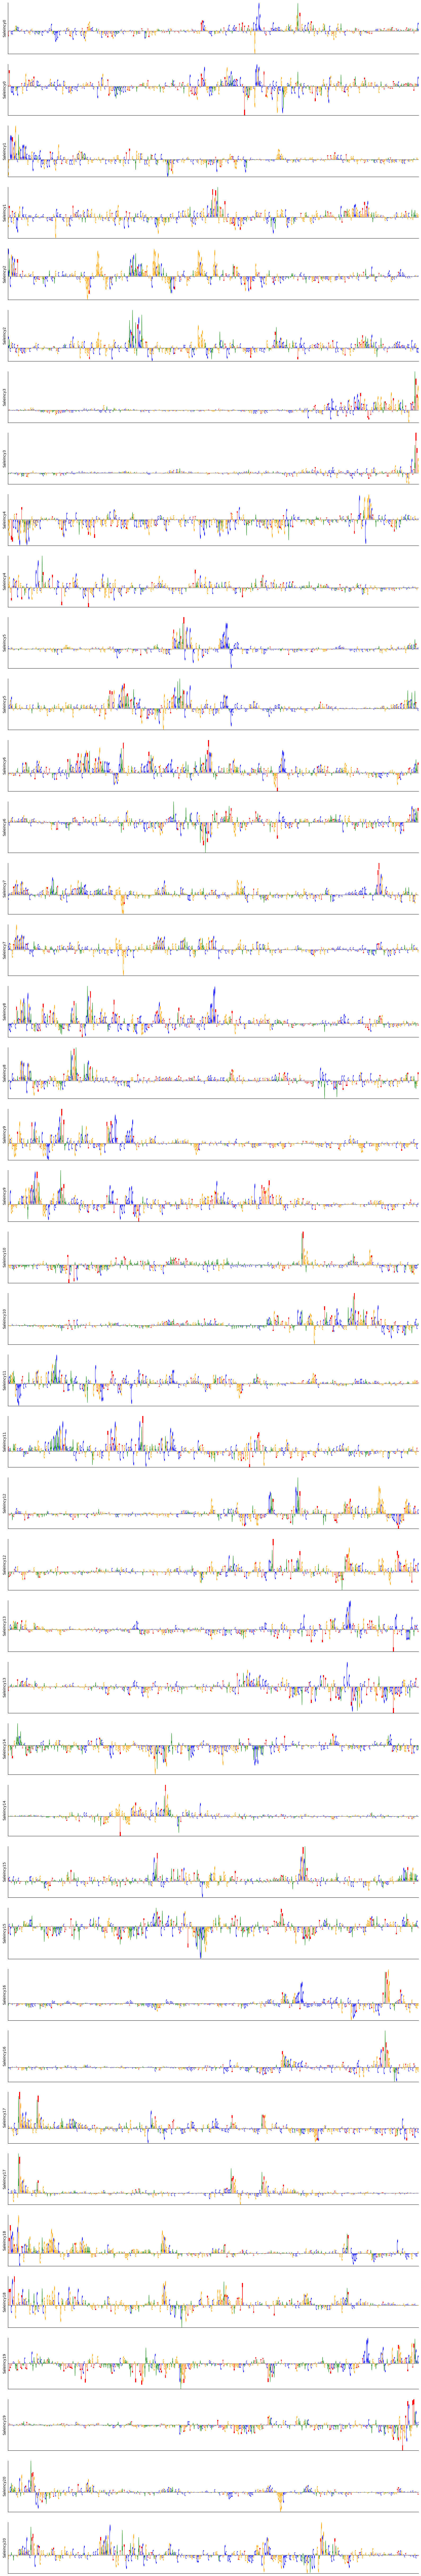

In [ ]:
## Exp
### Select the indices shared by both models in the cluster selected. For instance, here we chose the cluster0 for each model, and hence we are comparing
# the saliency maps of the shared peaks.
common=[6162, 10261, 21, 14388, 2120, 22604, 14416, 10330, 10337, 22627, 2148, 6244, 20582, 18537, 2161, 8309, 12423, 12433, 20642, 12471, 20674]

trained_model = '/home/tianhao/best_models/thymus1_exp_0729.h5'
### Change the type of model
model=base_exp((1344, 4))

# compile model
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.95,beta_2=0.9995)
model.compile(loss=loss_fn, optimizer=optimizer,
                  metrics=[tf.keras.metrics.AUC(name='auc', curve='ROC', multi_label=True),
                           tf.keras.metrics.AUC(name='auc_pr', curve='PR', multi_label=True)])
# load model
model.load_weights(trained_model)
### Can change func to others, like max. Default is mean
explainer_exp = Explainer(model, class_index=0, func=tf.math.reduce_mean)


## GeLU
### Change the path here
trained_model = '/home/tianhao/best_models/thymus1_relu_0729.h5'
### Change the type of model
model2=base_relu((1344, 4))

# compile model
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.95,beta_2=0.9995)
model2.compile(loss=loss_fn, optimizer=optimizer,
                  metrics=[tf.keras.metrics.AUC(name='auc', curve='ROC', multi_label=True),
                           tf.keras.metrics.AUC(name='auc_pr', curve='PR', multi_label=True)])
# load model
model2.load_weights(trained_model)
### Can change func to others, like max. Default is mean
explainer_exp2 = Explainer(model2, class_index=0, func=tf.math.reduce_mean)


fig = plt.figure(figsize=(20,len(common)*6))

X = x_test[common,:,:]

for index in range(len(common)):
    # saliency maps
    saliency_scores_exp = explainer_exp.saliency(X)
    saliency_scores_exp = grad_correction(saliency_scores_exp)
    scores = np.expand_dims(saliency_scores_exp[index], axis=0)
    saliency_df = grad_times_input_to_df(X[index], scores)
    # Whole sequence

    ax = plt.subplot(2*len(common),1, 2 * index +1)
    plot_attribution_map(saliency_df, ax, figsize=(20,3))
    plt.ylabel(('Saleincy'+str(index)))
    saliency_scores_exp2 = explainer_exp2.saliency(X)
    saliency_scores_exp2 = grad_correction(saliency_scores_exp2)
    scores = np.expand_dims(saliency_scores_exp2[index], axis=0)
    saliency_df = grad_times_input_to_df(X[index], scores)
    ax = plt.subplot(2*len(common),1, 2 * index +2)
    plot_attribution_map(saliency_df, ax, figsize=(20,3))
    plt.ylabel(('Saleincy'+str(index)))
plt.savefig("/home/tianhao/complete_seq_sal.pdf", format="pdf", bbox_inches="tight")

for index in range(len(common)):
    # saliency maps
    saliency_scores_exp = explainer_exp.saliency(X)
    saliency_scores_exp = grad_correction(saliency_scores_exp)
    scores = np.expand_dims(saliency_scores_exp[index], axis=0)
    saliency_df = grad_times_input_to_df(X[index], scores)
    # Whole sequence

    ax = plt.subplot(2*len(common),1, 2 * index +1)
    plot_attribution_map(saliency_df[400:800], ax, figsize=(20,3))
    plt.ylabel(('Saleincy'+str(index)))
    saliency_scores_exp2 = explainer_exp2.saliency(X)
    saliency_scores_exp2 = grad_correction(saliency_scores_exp2)
    scores = np.expand_dims(saliency_scores_exp2[index], axis=0)
    saliency_df = grad_times_input_to_df(X[index], scores)
    ax = plt.subplot(2*len(common),1, 2 * index +2)
    plot_attribution_map(saliency_df[400:800], ax, figsize=(20,3))
    plt.ylabel(('Saleincy'+str(index)))
plt.savefig("/home/tianhao/complete_seq_sal_zoomin.pdf", format="pdf", bbox_inches="tight")


In [ ]:
def filter_max_align_batch(X, model, layer=3, window=24, threshold=0.5, batch_size=1024, max_align=1e4, verbose=1):
  """get alignment of filter activations for visualization"""
  if verbose:
    print("Calculating filter PPM based on activation-based alignments")

  N,L,A = X.shape
  num_filters = model.layers[layer].output.shape[2]

  # Set the left and right window sizes
  window_left = int(window/2)
  window_right = window - window_left

  # get feature maps of 1st convolutional layer after activation
  intermediate = keras.Model(inputs=model.inputs, outputs=model.layers[layer].output)

  # batch the data
  dataset = tf.data.Dataset.from_tensor_slices(X)
  batches = dataset.batch(batch_size)

  # loop over batches to capture MAX activation
  if verbose:
    print('  Calculating MAX activation')
  MAX = np.zeros(num_filters)
  for x in batches:

    # get feature map for mini-batch
    fmap = intermediate.predict(x, verbose=0)

    # loop over each filter to find "active" positions
    for f in range(num_filters):
      MAX[f] = np.maximum(MAX[f], np.max(fmap[:,:,f]))


  # loop over each filter to find "active" positions
  W = []
  counts = []
  for f in tqdm(range(num_filters)):
    if verbose:
      print("    processing %d out of %d filters"%(f+1, num_filters))
    status = 0

    # compile sub-model to get feature map
    intermediate = keras.Model(inputs=model.inputs, outputs=model.layers[layer].output[:,:,f])

    # loop over each batch
    #dataset = tf.data.Dataset.from_tensor_slices(X)
    seq_align_sum = np.zeros((window, A)) # running sum
    counter = 0                            # counts the number of sequences in alignment
    status = 1                            # monitors whether depth of alignment has reached max_align
    for x in batches:
      if status:

        # get feature map for a batch sequences
        fmaps = intermediate.predict(x, verbose=0)

        # Find regions above threshold
        for data_index, fmap in enumerate(fmaps):
          if status:
            pos_index = np.where(fmap > MAX[f] * threshold)[0]

            # Make a sequence alignment centered about each activation (above threshold)
            for i in range(len(pos_index)):
              if status:
                # Determine position of window about each filter activation
                start_window = pos_index[i] - window_left
                end_window = pos_index[i] + window_right

                # Check to make sure positions are valid
                if (start_window > 0) & (end_window < L):
                  seq_align_sum += x[data_index,start_window:end_window,:].numpy()
                  counter += 1
                  if counter == max_align:
                    status = 0
                else:
                  break
          else:
            break
      else:
        if verbose:
          print("      alignment has reached max depth for all filters")
        break

    # calculate position probability matrix of filter
    if verbose:
      print("      %d sub-sequences above threshold"%(counter))
    if counter > 0:
      W.append(seq_align_sum/counter)
    else:
      W.append(np.ones((window,A))/A)
    counts.append(counter)
  return np.array(W), np.array(counts)

# plot filters
def plot_filters(W, fig, num_cols=8, alphabet='ACGT', names=None, y_labels=None, fontsize=12):
  """plot 1st layer convolutional filters"""

  num_filter, filter_len, A = W.shape
  num_rows = np.ceil(num_filter/num_cols).astype(int)

  fig.subplots_adjust(hspace=0.2, wspace=0.2)
  for n, w in enumerate(W):
    ax = fig.add_subplot(num_rows,num_cols,n+1)

    # Calculate sequence logo heights -- information
    I = np.log2(4) + np.sum(w * np.log2(w+1e-7), axis=1, keepdims=True)
    logo = I*w

    # Create DataFrame for logomaker
    counts_df = pd.DataFrame(data=0.0, columns=list(alphabet), index=list(range(filter_len)))
    for a in range(A):
      for l in range(filter_len):
        counts_df.iloc[l,a] = logo[l,a]

    logomaker.Logo(counts_df, ax=ax)
    ax = plt.gca()
    ax.set_ylim(0,2)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    plt.xticks([])
    plt.yticks([])
    if names is not None:
        ax.title.set_text(names[n])
    if y_labels is not None:
        plt.ylabel(f"filter {y_labels[n]}", fontsize=fontsize)

    plt.tight_layout()



Calculating filter PPM based on activation-based alignments
  Calculating MAX activation


  0%|          | 0/288 [00:00<?, ?it/s]

    processing 1 out of 288 filters


  0%|          | 1/288 [00:03<17:18,  3.62s/it]

      55 sub-sequences above threshold
    processing 2 out of 288 filters


  1%|          | 2/288 [00:08<19:29,  4.09s/it]

      125 sub-sequences above threshold
    processing 3 out of 288 filters


  1%|          | 3/288 [00:13<22:44,  4.79s/it]

      470 sub-sequences above threshold
    processing 4 out of 288 filters


  1%|▏         | 4/288 [00:17<20:38,  4.36s/it]

      141 sub-sequences above threshold
    processing 5 out of 288 filters


  2%|▏         | 5/288 [00:20<19:07,  4.05s/it]

      103 sub-sequences above threshold
    processing 6 out of 288 filters


  2%|▏         | 6/288 [00:24<18:20,  3.90s/it]

      93 sub-sequences above threshold
    processing 7 out of 288 filters


  2%|▏         | 7/288 [00:28<17:42,  3.78s/it]

      107 sub-sequences above threshold
    processing 8 out of 288 filters


  3%|▎         | 8/288 [00:31<17:53,  3.83s/it]

      1054 sub-sequences above threshold
    processing 9 out of 288 filters


  3%|▎         | 9/288 [00:35<17:24,  3.74s/it]

      85 sub-sequences above threshold
    processing 10 out of 288 filters


  3%|▎         | 10/288 [00:39<17:05,  3.69s/it]

      73 sub-sequences above threshold
    processing 11 out of 288 filters


  4%|▍         | 11/288 [00:42<16:51,  3.65s/it]

      40 sub-sequences above threshold
    processing 12 out of 288 filters


  4%|▍         | 12/288 [00:46<16:32,  3.60s/it]

      199 sub-sequences above threshold
    processing 13 out of 288 filters


  5%|▍         | 13/288 [00:49<16:33,  3.61s/it]

      410 sub-sequences above threshold
    processing 14 out of 288 filters


  5%|▍         | 14/288 [00:53<16:30,  3.62s/it]

      111 sub-sequences above threshold
    processing 15 out of 288 filters


  5%|▌         | 15/288 [00:56<16:21,  3.59s/it]

      13 sub-sequences above threshold
    processing 16 out of 288 filters


  6%|▌         | 16/288 [01:00<16:14,  3.58s/it]

      17 sub-sequences above threshold
    processing 17 out of 288 filters


  6%|▌         | 17/288 [01:04<16:18,  3.61s/it]

      165 sub-sequences above threshold
    processing 18 out of 288 filters


  6%|▋         | 18/288 [01:07<16:21,  3.63s/it]

      407 sub-sequences above threshold
    processing 19 out of 288 filters


  7%|▋         | 19/288 [01:11<16:00,  3.57s/it]

      15 sub-sequences above threshold
    processing 20 out of 288 filters


  7%|▋         | 20/288 [01:14<15:50,  3.55s/it]

      47 sub-sequences above threshold
    processing 21 out of 288 filters


  7%|▋         | 21/288 [01:18<15:42,  3.53s/it]

      68 sub-sequences above threshold
    processing 22 out of 288 filters


  8%|▊         | 22/288 [01:21<15:39,  3.53s/it]

      64 sub-sequences above threshold
    processing 23 out of 288 filters


  8%|▊         | 23/288 [01:25<15:46,  3.57s/it]

      340 sub-sequences above threshold
    processing 24 out of 288 filters


  8%|▊         | 24/288 [01:29<15:51,  3.60s/it]

      264 sub-sequences above threshold
    processing 25 out of 288 filters


  9%|▊         | 25/288 [01:32<15:41,  3.58s/it]

      10 sub-sequences above threshold
    processing 26 out of 288 filters


  9%|▉         | 26/288 [01:36<15:43,  3.60s/it]

      166 sub-sequences above threshold
    processing 27 out of 288 filters


  9%|▉         | 27/288 [01:39<15:44,  3.62s/it]

      176 sub-sequences above threshold
    processing 28 out of 288 filters


 10%|▉         | 28/288 [01:43<15:35,  3.60s/it]

      25 sub-sequences above threshold
    processing 29 out of 288 filters


 10%|█         | 29/288 [01:47<15:29,  3.59s/it]

      89 sub-sequences above threshold
    processing 30 out of 288 filters


 10%|█         | 30/288 [01:50<15:23,  3.58s/it]

      89 sub-sequences above threshold
    processing 31 out of 288 filters


 11%|█         | 31/288 [01:54<15:15,  3.56s/it]

      43 sub-sequences above threshold
    processing 32 out of 288 filters


 11%|█         | 32/288 [01:57<15:08,  3.55s/it]

      42 sub-sequences above threshold
    processing 33 out of 288 filters


 11%|█▏        | 33/288 [02:01<15:06,  3.55s/it]

      169 sub-sequences above threshold
    processing 34 out of 288 filters


 12%|█▏        | 34/288 [02:04<14:58,  3.54s/it]

      169 sub-sequences above threshold
    processing 35 out of 288 filters


 12%|█▏        | 35/288 [02:08<15:03,  3.57s/it]

      190 sub-sequences above threshold
    processing 36 out of 288 filters


 12%|█▎        | 36/288 [02:11<14:52,  3.54s/it]

      157 sub-sequences above threshold
    processing 37 out of 288 filters


 13%|█▎        | 37/288 [02:15<14:48,  3.54s/it]

      17 sub-sequences above threshold
    processing 38 out of 288 filters


 13%|█▎        | 38/288 [02:19<14:59,  3.60s/it]

      460 sub-sequences above threshold
    processing 39 out of 288 filters


 14%|█▎        | 39/288 [02:22<14:40,  3.54s/it]

      25 sub-sequences above threshold
    processing 40 out of 288 filters


 14%|█▍        | 40/288 [02:26<14:34,  3.52s/it]

      28 sub-sequences above threshold
    processing 41 out of 288 filters


 14%|█▍        | 41/288 [02:29<14:30,  3.52s/it]

      50 sub-sequences above threshold
    processing 42 out of 288 filters


 15%|█▍        | 42/288 [02:32<14:17,  3.48s/it]

      56 sub-sequences above threshold
    processing 43 out of 288 filters


 15%|█▍        | 43/288 [02:36<14:23,  3.52s/it]

      15 sub-sequences above threshold
    processing 44 out of 288 filters


 15%|█▌        | 44/288 [02:39<14:06,  3.47s/it]

      11 sub-sequences above threshold
    processing 45 out of 288 filters


 16%|█▌        | 45/288 [02:43<14:06,  3.48s/it]

      23 sub-sequences above threshold
    processing 46 out of 288 filters


 16%|█▌        | 46/288 [02:46<14:01,  3.48s/it]

      16 sub-sequences above threshold
    processing 47 out of 288 filters


 16%|█▋        | 47/288 [02:50<14:09,  3.52s/it]

      81 sub-sequences above threshold
    processing 48 out of 288 filters


 17%|█▋        | 48/288 [02:53<13:57,  3.49s/it]

      12 sub-sequences above threshold
    processing 49 out of 288 filters


 17%|█▋        | 49/288 [02:57<14:07,  3.55s/it]

      68 sub-sequences above threshold
    processing 50 out of 288 filters


 17%|█▋        | 50/288 [03:01<14:03,  3.54s/it]

      53 sub-sequences above threshold
    processing 51 out of 288 filters


 18%|█▊        | 51/288 [03:04<13:56,  3.53s/it]

      17 sub-sequences above threshold
    processing 52 out of 288 filters


 18%|█▊        | 52/288 [03:08<13:49,  3.51s/it]

      29 sub-sequences above threshold
    processing 53 out of 288 filters


 18%|█▊        | 53/288 [03:11<13:55,  3.55s/it]

      34 sub-sequences above threshold
    processing 54 out of 288 filters


 19%|█▉        | 54/288 [03:15<13:44,  3.52s/it]

      17 sub-sequences above threshold
    processing 55 out of 288 filters


 19%|█▉        | 55/288 [03:19<14:44,  3.80s/it]

      69 sub-sequences above threshold
    processing 56 out of 288 filters


 19%|█▉        | 56/288 [03:23<14:13,  3.68s/it]

      108 sub-sequences above threshold
    processing 57 out of 288 filters


 20%|█▉        | 57/288 [03:26<14:09,  3.68s/it]

      978 sub-sequences above threshold
    processing 58 out of 288 filters


 20%|██        | 58/288 [03:30<13:40,  3.57s/it]

      15 sub-sequences above threshold
    processing 59 out of 288 filters


 20%|██        | 59/288 [03:33<13:19,  3.49s/it]

      186 sub-sequences above threshold
    processing 60 out of 288 filters


 21%|██        | 60/288 [03:36<12:59,  3.42s/it]

      53 sub-sequences above threshold
    processing 61 out of 288 filters


 21%|██        | 61/288 [03:39<12:42,  3.36s/it]

      80 sub-sequences above threshold
    processing 62 out of 288 filters


 22%|██▏       | 62/288 [03:43<12:37,  3.35s/it]

      81 sub-sequences above threshold
    processing 63 out of 288 filters


 22%|██▏       | 63/288 [03:46<12:31,  3.34s/it]

      31 sub-sequences above threshold
    processing 64 out of 288 filters


 22%|██▏       | 64/288 [03:49<12:25,  3.33s/it]

      56 sub-sequences above threshold
    processing 65 out of 288 filters


 23%|██▎       | 65/288 [03:52<12:13,  3.29s/it]

      78 sub-sequences above threshold
    processing 66 out of 288 filters


 23%|██▎       | 66/288 [03:56<12:27,  3.37s/it]

      92 sub-sequences above threshold
    processing 67 out of 288 filters


 23%|██▎       | 67/288 [04:00<13:16,  3.60s/it]

      1603 sub-sequences above threshold
    processing 68 out of 288 filters


 24%|██▎       | 68/288 [04:04<12:56,  3.53s/it]

      32 sub-sequences above threshold
    processing 69 out of 288 filters


 24%|██▍       | 69/288 [04:07<12:49,  3.52s/it]

      316 sub-sequences above threshold
    processing 70 out of 288 filters


 24%|██▍       | 70/288 [04:10<12:39,  3.49s/it]

      41 sub-sequences above threshold
    processing 71 out of 288 filters


 25%|██▍       | 71/288 [04:14<12:34,  3.48s/it]

      388 sub-sequences above threshold
    processing 72 out of 288 filters


 25%|██▌       | 72/288 [04:17<12:23,  3.44s/it]

      43 sub-sequences above threshold
    processing 73 out of 288 filters


 25%|██▌       | 73/288 [04:20<12:06,  3.38s/it]

      59 sub-sequences above threshold
    processing 74 out of 288 filters


 26%|██▌       | 74/288 [04:24<11:50,  3.32s/it]

      13 sub-sequences above threshold
    processing 75 out of 288 filters


 26%|██▌       | 75/288 [04:27<11:43,  3.30s/it]

      16 sub-sequences above threshold
    processing 76 out of 288 filters


 26%|██▋       | 76/288 [04:30<11:25,  3.23s/it]

      3 sub-sequences above threshold
    processing 77 out of 288 filters


 27%|██▋       | 77/288 [04:33<11:23,  3.24s/it]

      62 sub-sequences above threshold
    processing 78 out of 288 filters


 27%|██▋       | 78/288 [04:37<11:28,  3.28s/it]

      229 sub-sequences above threshold
    processing 79 out of 288 filters


 27%|██▋       | 79/288 [04:40<11:21,  3.26s/it]

      283 sub-sequences above threshold
    processing 80 out of 288 filters


 28%|██▊       | 80/288 [04:43<11:26,  3.30s/it]

      374 sub-sequences above threshold
    processing 81 out of 288 filters


 28%|██▊       | 81/288 [04:46<11:21,  3.29s/it]

      72 sub-sequences above threshold
    processing 82 out of 288 filters


 28%|██▊       | 82/288 [04:50<11:16,  3.28s/it]

      50 sub-sequences above threshold
    processing 83 out of 288 filters


 29%|██▉       | 83/288 [04:53<11:15,  3.30s/it]

      41 sub-sequences above threshold
    processing 84 out of 288 filters


 29%|██▉       | 84/288 [04:56<11:07,  3.27s/it]

      65 sub-sequences above threshold
    processing 85 out of 288 filters


 30%|██▉       | 85/288 [05:00<11:05,  3.28s/it]

      132 sub-sequences above threshold
    processing 86 out of 288 filters


 30%|██▉       | 86/288 [05:03<10:44,  3.19s/it]

      5 sub-sequences above threshold
    processing 87 out of 288 filters


 30%|███       | 87/288 [05:06<10:43,  3.20s/it]

      30 sub-sequences above threshold
    processing 88 out of 288 filters


 31%|███       | 88/288 [05:09<10:38,  3.19s/it]

      13 sub-sequences above threshold
    processing 89 out of 288 filters


 31%|███       | 89/288 [05:12<10:34,  3.19s/it]

      57 sub-sequences above threshold
    processing 90 out of 288 filters


 31%|███▏      | 90/288 [05:15<10:36,  3.21s/it]

      91 sub-sequences above threshold
    processing 91 out of 288 filters


 32%|███▏      | 91/288 [05:19<10:29,  3.19s/it]

      6 sub-sequences above threshold
    processing 92 out of 288 filters


 32%|███▏      | 92/288 [05:22<10:33,  3.23s/it]

      41 sub-sequences above threshold
    processing 93 out of 288 filters


 32%|███▏      | 93/288 [05:25<10:25,  3.21s/it]

      24 sub-sequences above threshold
    processing 94 out of 288 filters


 33%|███▎      | 94/288 [05:28<10:19,  3.20s/it]

      30 sub-sequences above threshold
    processing 95 out of 288 filters


 33%|███▎      | 95/288 [05:31<10:18,  3.21s/it]

      45 sub-sequences above threshold
    processing 96 out of 288 filters


 33%|███▎      | 96/288 [05:35<10:25,  3.26s/it]

      18 sub-sequences above threshold
    processing 97 out of 288 filters


 34%|███▎      | 97/288 [05:38<10:22,  3.26s/it]

      444 sub-sequences above threshold
    processing 98 out of 288 filters


 34%|███▍      | 98/288 [05:41<10:19,  3.26s/it]

      25 sub-sequences above threshold
    processing 99 out of 288 filters


 34%|███▍      | 99/288 [05:45<10:23,  3.30s/it]

      180 sub-sequences above threshold
    processing 100 out of 288 filters


 35%|███▍      | 100/288 [05:48<10:23,  3.32s/it]

      9 sub-sequences above threshold
    processing 101 out of 288 filters


 35%|███▌      | 101/288 [05:51<10:13,  3.28s/it]

      83 sub-sequences above threshold
    processing 102 out of 288 filters


 35%|███▌      | 102/288 [05:55<10:12,  3.29s/it]

      63 sub-sequences above threshold
    processing 103 out of 288 filters


 36%|███▌      | 103/288 [05:58<10:08,  3.29s/it]

      27 sub-sequences above threshold
    processing 104 out of 288 filters


 36%|███▌      | 104/288 [06:01<10:04,  3.29s/it]

      123 sub-sequences above threshold
    processing 105 out of 288 filters


 36%|███▋      | 105/288 [06:05<10:04,  3.30s/it]

      64 sub-sequences above threshold
    processing 106 out of 288 filters


 37%|███▋      | 106/288 [06:08<10:05,  3.33s/it]

      429 sub-sequences above threshold
    processing 107 out of 288 filters


 37%|███▋      | 107/288 [06:11<09:53,  3.28s/it]

      26 sub-sequences above threshold
    processing 108 out of 288 filters


 38%|███▊      | 108/288 [06:16<10:56,  3.65s/it]

      88 sub-sequences above threshold
    processing 109 out of 288 filters


 38%|███▊      | 109/288 [06:19<10:33,  3.54s/it]

      27 sub-sequences above threshold
    processing 110 out of 288 filters


 38%|███▊      | 110/288 [06:22<10:20,  3.48s/it]

      45 sub-sequences above threshold
    processing 111 out of 288 filters


 39%|███▊      | 111/288 [06:26<10:08,  3.44s/it]

      158 sub-sequences above threshold
    processing 112 out of 288 filters


 39%|███▉      | 112/288 [06:29<10:18,  3.52s/it]

      1140 sub-sequences above threshold
    processing 113 out of 288 filters


 39%|███▉      | 113/288 [06:33<10:06,  3.46s/it]

      272 sub-sequences above threshold
    processing 114 out of 288 filters


 40%|███▉      | 114/288 [06:36<09:51,  3.40s/it]

      20 sub-sequences above threshold
    processing 115 out of 288 filters


 40%|███▉      | 115/288 [06:39<09:40,  3.36s/it]

      17 sub-sequences above threshold
    processing 116 out of 288 filters


 40%|████      | 116/288 [06:42<09:35,  3.35s/it]

      156 sub-sequences above threshold
    processing 117 out of 288 filters


 41%|████      | 117/288 [06:46<09:42,  3.40s/it]

      717 sub-sequences above threshold
    processing 118 out of 288 filters


 41%|████      | 118/288 [06:49<09:30,  3.35s/it]

      52 sub-sequences above threshold
    processing 119 out of 288 filters


 41%|████▏     | 119/288 [06:52<09:21,  3.32s/it]

      57 sub-sequences above threshold
    processing 120 out of 288 filters


 42%|████▏     | 120/288 [06:56<09:17,  3.32s/it]

      2 sub-sequences above threshold
    processing 121 out of 288 filters


 42%|████▏     | 121/288 [06:59<09:35,  3.44s/it]

      1401 sub-sequences above threshold
    processing 122 out of 288 filters


 42%|████▏     | 122/288 [07:04<10:49,  3.91s/it]

      4656 sub-sequences above threshold
    processing 123 out of 288 filters


 43%|████▎     | 123/288 [07:08<10:15,  3.73s/it]

      66 sub-sequences above threshold
    processing 124 out of 288 filters


 43%|████▎     | 124/288 [07:11<09:44,  3.56s/it]

      12 sub-sequences above threshold
    processing 125 out of 288 filters


 43%|████▎     | 125/288 [07:14<09:23,  3.46s/it]

      75 sub-sequences above threshold
    processing 126 out of 288 filters


 44%|████▍     | 126/288 [07:17<09:09,  3.39s/it]

      35 sub-sequences above threshold
    processing 127 out of 288 filters


 44%|████▍     | 127/288 [07:21<09:00,  3.36s/it]

      111 sub-sequences above threshold
    processing 128 out of 288 filters


 44%|████▍     | 128/288 [07:24<08:58,  3.36s/it]

      89 sub-sequences above threshold
    processing 129 out of 288 filters


 45%|████▍     | 129/288 [07:27<08:42,  3.28s/it]

      17 sub-sequences above threshold
    processing 130 out of 288 filters


 45%|████▌     | 130/288 [07:31<08:43,  3.31s/it]

      36 sub-sequences above threshold
    processing 131 out of 288 filters


 45%|████▌     | 131/288 [07:34<08:34,  3.27s/it]

      13 sub-sequences above threshold
    processing 132 out of 288 filters


 46%|████▌     | 132/288 [07:37<08:48,  3.39s/it]

      833 sub-sequences above threshold
    processing 133 out of 288 filters


 46%|████▌     | 133/288 [07:41<08:38,  3.34s/it]

      56 sub-sequences above threshold
    processing 134 out of 288 filters


 47%|████▋     | 134/288 [07:44<08:31,  3.32s/it]

      18 sub-sequences above threshold
    processing 135 out of 288 filters


 47%|████▋     | 135/288 [07:47<08:29,  3.33s/it]

      179 sub-sequences above threshold
    processing 136 out of 288 filters


 47%|████▋     | 136/288 [07:51<08:24,  3.32s/it]

      88 sub-sequences above threshold
    processing 137 out of 288 filters


 48%|████▊     | 137/288 [07:54<08:22,  3.33s/it]

      493 sub-sequences above threshold
    processing 138 out of 288 filters


 48%|████▊     | 138/288 [07:57<08:16,  3.31s/it]

      80 sub-sequences above threshold
    processing 139 out of 288 filters


 48%|████▊     | 139/288 [08:01<08:16,  3.33s/it]

      58 sub-sequences above threshold
    processing 140 out of 288 filters


 49%|████▊     | 140/288 [08:04<08:04,  3.27s/it]

      44 sub-sequences above threshold
    processing 141 out of 288 filters


 49%|████▉     | 141/288 [08:07<08:12,  3.35s/it]

      195 sub-sequences above threshold
    processing 142 out of 288 filters


 49%|████▉     | 142/288 [08:11<08:07,  3.34s/it]

      403 sub-sequences above threshold
    processing 143 out of 288 filters


 50%|████▉     | 143/288 [08:14<08:02,  3.33s/it]

      7 sub-sequences above threshold
    processing 144 out of 288 filters


 50%|█████     | 144/288 [08:17<07:56,  3.31s/it]

      115 sub-sequences above threshold
    processing 145 out of 288 filters


 50%|█████     | 145/288 [08:20<07:49,  3.29s/it]

      42 sub-sequences above threshold
    processing 146 out of 288 filters


 51%|█████     | 146/288 [08:24<07:47,  3.29s/it]

      20 sub-sequences above threshold
    processing 147 out of 288 filters


 51%|█████     | 147/288 [08:27<07:47,  3.31s/it]

      42 sub-sequences above threshold
    processing 148 out of 288 filters


 51%|█████▏    | 148/288 [08:30<07:44,  3.31s/it]

      98 sub-sequences above threshold
    processing 149 out of 288 filters


 52%|█████▏    | 149/288 [08:34<07:41,  3.32s/it]

      39 sub-sequences above threshold
    processing 150 out of 288 filters


 52%|█████▏    | 150/288 [08:37<07:31,  3.27s/it]

      210 sub-sequences above threshold
    processing 151 out of 288 filters


 52%|█████▏    | 151/288 [08:40<07:39,  3.36s/it]

      1078 sub-sequences above threshold
    processing 152 out of 288 filters


 53%|█████▎    | 152/288 [08:44<07:37,  3.37s/it]

      433 sub-sequences above threshold
    processing 153 out of 288 filters


 53%|█████▎    | 153/288 [08:47<07:28,  3.32s/it]

      13 sub-sequences above threshold
    processing 154 out of 288 filters


 53%|█████▎    | 154/288 [08:50<07:24,  3.32s/it]

      128 sub-sequences above threshold
    processing 155 out of 288 filters


 54%|█████▍    | 155/288 [08:54<07:17,  3.29s/it]

      89 sub-sequences above threshold
    processing 156 out of 288 filters


 54%|█████▍    | 156/288 [08:57<07:22,  3.35s/it]

      183 sub-sequences above threshold
    processing 157 out of 288 filters


 55%|█████▍    | 157/288 [09:00<07:10,  3.29s/it]

      17 sub-sequences above threshold
    processing 158 out of 288 filters


 55%|█████▍    | 158/288 [09:03<07:08,  3.30s/it]

      33 sub-sequences above threshold
    processing 159 out of 288 filters


 55%|█████▌    | 159/288 [09:07<07:05,  3.30s/it]

      48 sub-sequences above threshold
    processing 160 out of 288 filters


 56%|█████▌    | 160/288 [09:10<07:10,  3.36s/it]

      212 sub-sequences above threshold
    processing 161 out of 288 filters


 56%|█████▌    | 161/288 [09:14<07:03,  3.33s/it]

      286 sub-sequences above threshold
    processing 162 out of 288 filters


 56%|█████▋    | 162/288 [09:18<07:25,  3.54s/it]

      29 sub-sequences above threshold
    processing 163 out of 288 filters


 57%|█████▋    | 163/288 [09:21<07:15,  3.48s/it]

      39 sub-sequences above threshold
    processing 164 out of 288 filters


 57%|█████▋    | 164/288 [09:24<07:03,  3.41s/it]

      24 sub-sequences above threshold
    processing 165 out of 288 filters


 57%|█████▋    | 165/288 [09:27<06:54,  3.37s/it]

      15 sub-sequences above threshold
    processing 166 out of 288 filters


 58%|█████▊    | 166/288 [09:31<06:51,  3.37s/it]

      84 sub-sequences above threshold
    processing 167 out of 288 filters


 58%|█████▊    | 167/288 [09:34<06:42,  3.33s/it]

      42 sub-sequences above threshold
    processing 168 out of 288 filters


 58%|█████▊    | 168/288 [09:37<06:37,  3.31s/it]

      19 sub-sequences above threshold
    processing 169 out of 288 filters


 59%|█████▊    | 169/288 [09:41<06:33,  3.31s/it]

      49 sub-sequences above threshold
    processing 170 out of 288 filters


 59%|█████▉    | 170/288 [09:44<06:30,  3.31s/it]

      35 sub-sequences above threshold
    processing 171 out of 288 filters


 59%|█████▉    | 171/288 [09:47<06:21,  3.26s/it]

      12 sub-sequences above threshold
    processing 172 out of 288 filters


 60%|█████▉    | 172/288 [09:50<06:22,  3.30s/it]

      67 sub-sequences above threshold
    processing 173 out of 288 filters


 60%|██████    | 173/288 [09:54<06:26,  3.36s/it]

      232 sub-sequences above threshold
    processing 174 out of 288 filters


 60%|██████    | 174/288 [09:57<06:16,  3.30s/it]

      82 sub-sequences above threshold
    processing 175 out of 288 filters


 61%|██████    | 175/288 [10:01<06:37,  3.52s/it]

      1644 sub-sequences above threshold
    processing 176 out of 288 filters


 61%|██████    | 176/288 [10:04<06:24,  3.43s/it]

      26 sub-sequences above threshold
    processing 177 out of 288 filters


 61%|██████▏   | 177/288 [10:08<06:18,  3.41s/it]

      231 sub-sequences above threshold
    processing 178 out of 288 filters


 62%|██████▏   | 178/288 [10:11<06:11,  3.38s/it]

      68 sub-sequences above threshold
    processing 179 out of 288 filters


 62%|██████▏   | 179/288 [10:14<06:03,  3.34s/it]

      43 sub-sequences above threshold
    processing 180 out of 288 filters


 62%|██████▎   | 180/288 [10:18<05:59,  3.33s/it]

      35 sub-sequences above threshold
    processing 181 out of 288 filters


 63%|██████▎   | 181/288 [10:21<05:53,  3.30s/it]

      70 sub-sequences above threshold
    processing 182 out of 288 filters


 63%|██████▎   | 182/288 [10:24<05:46,  3.27s/it]

      7 sub-sequences above threshold
    processing 183 out of 288 filters


 64%|██████▎   | 183/288 [10:27<05:45,  3.29s/it]

      74 sub-sequences above threshold
    processing 184 out of 288 filters


 64%|██████▍   | 184/288 [10:31<05:41,  3.28s/it]

      16 sub-sequences above threshold
    processing 185 out of 288 filters


 64%|██████▍   | 185/288 [10:34<05:40,  3.31s/it]

      456 sub-sequences above threshold
    processing 186 out of 288 filters


 65%|██████▍   | 186/288 [10:37<05:41,  3.34s/it]

      105 sub-sequences above threshold
    processing 187 out of 288 filters


 65%|██████▍   | 187/288 [10:41<05:54,  3.51s/it]

      144 sub-sequences above threshold
    processing 188 out of 288 filters


 65%|██████▌   | 188/288 [10:45<05:50,  3.51s/it]

      75 sub-sequences above threshold
    processing 189 out of 288 filters


 66%|██████▌   | 189/288 [10:48<05:40,  3.44s/it]

      40 sub-sequences above threshold
    processing 190 out of 288 filters


 66%|██████▌   | 190/288 [10:52<05:36,  3.43s/it]

      7 sub-sequences above threshold
    processing 191 out of 288 filters


 66%|██████▋   | 191/288 [10:56<05:50,  3.61s/it]

      122 sub-sequences above threshold
    processing 192 out of 288 filters


 67%|██████▋   | 192/288 [10:59<05:36,  3.50s/it]

      34 sub-sequences above threshold
    processing 193 out of 288 filters


 67%|██████▋   | 193/288 [11:02<05:26,  3.44s/it]

      56 sub-sequences above threshold
    processing 194 out of 288 filters


 67%|██████▋   | 194/288 [11:05<05:20,  3.41s/it]

      83 sub-sequences above threshold
    processing 195 out of 288 filters


 68%|██████▊   | 195/288 [11:09<05:14,  3.38s/it]

      95 sub-sequences above threshold
    processing 196 out of 288 filters


 68%|██████▊   | 196/288 [11:12<05:11,  3.39s/it]

      179 sub-sequences above threshold
    processing 197 out of 288 filters


 68%|██████▊   | 197/288 [11:16<05:14,  3.45s/it]

      853 sub-sequences above threshold
    processing 198 out of 288 filters


 69%|██████▉   | 198/288 [11:19<05:03,  3.37s/it]

      31 sub-sequences above threshold
    processing 199 out of 288 filters


 69%|██████▉   | 199/288 [11:22<04:52,  3.29s/it]

      18 sub-sequences above threshold
    processing 200 out of 288 filters


 69%|██████▉   | 200/288 [11:25<04:47,  3.27s/it]

      34 sub-sequences above threshold
    processing 201 out of 288 filters


 70%|██████▉   | 201/288 [11:28<04:40,  3.22s/it]

      20 sub-sequences above threshold
    processing 202 out of 288 filters


 70%|███████   | 202/288 [11:32<04:40,  3.26s/it]

      218 sub-sequences above threshold
    processing 203 out of 288 filters


 70%|███████   | 203/288 [11:35<04:37,  3.26s/it]

      199 sub-sequences above threshold
    processing 204 out of 288 filters


 71%|███████   | 204/288 [11:38<04:33,  3.26s/it]

      122 sub-sequences above threshold
    processing 205 out of 288 filters


 71%|███████   | 205/288 [11:41<04:27,  3.22s/it]

      63 sub-sequences above threshold
    processing 206 out of 288 filters


 72%|███████▏  | 206/288 [11:45<04:23,  3.21s/it]

      33 sub-sequences above threshold
    processing 207 out of 288 filters


 72%|███████▏  | 207/288 [11:49<04:49,  3.58s/it]

      2592 sub-sequences above threshold
    processing 208 out of 288 filters


 72%|███████▏  | 208/288 [11:52<04:36,  3.46s/it]

      83 sub-sequences above threshold
    processing 209 out of 288 filters


 73%|███████▎  | 209/288 [11:56<04:32,  3.45s/it]

      159 sub-sequences above threshold
    processing 210 out of 288 filters


 73%|███████▎  | 210/288 [11:59<04:22,  3.37s/it]

      192 sub-sequences above threshold
    processing 211 out of 288 filters


 73%|███████▎  | 211/288 [12:02<04:17,  3.34s/it]

      159 sub-sequences above threshold
    processing 212 out of 288 filters


 74%|███████▎  | 212/288 [12:05<04:08,  3.27s/it]

      6 sub-sequences above threshold
    processing 213 out of 288 filters


 74%|███████▍  | 213/288 [12:09<04:07,  3.30s/it]

      165 sub-sequences above threshold
    processing 214 out of 288 filters


 74%|███████▍  | 214/288 [12:12<04:04,  3.31s/it]

      245 sub-sequences above threshold
    processing 215 out of 288 filters


 75%|███████▍  | 215/288 [12:16<04:22,  3.59s/it]

      55 sub-sequences above threshold
    processing 216 out of 288 filters


 75%|███████▌  | 216/288 [12:20<04:14,  3.53s/it]

      74 sub-sequences above threshold
    processing 217 out of 288 filters


 75%|███████▌  | 217/288 [12:23<04:02,  3.42s/it]

      8 sub-sequences above threshold
    processing 218 out of 288 filters


 76%|███████▌  | 218/288 [12:26<03:55,  3.37s/it]

      41 sub-sequences above threshold
    processing 219 out of 288 filters


 76%|███████▌  | 219/288 [12:29<03:51,  3.36s/it]

      260 sub-sequences above threshold
    processing 220 out of 288 filters


 76%|███████▋  | 220/288 [12:32<03:43,  3.29s/it]

      4 sub-sequences above threshold
    processing 221 out of 288 filters


 77%|███████▋  | 221/288 [12:36<03:42,  3.32s/it]

      655 sub-sequences above threshold
    processing 222 out of 288 filters


 77%|███████▋  | 222/288 [12:39<03:37,  3.29s/it]

      153 sub-sequences above threshold
    processing 223 out of 288 filters


 77%|███████▋  | 223/288 [12:42<03:32,  3.27s/it]

      22 sub-sequences above threshold
    processing 224 out of 288 filters


 78%|███████▊  | 224/288 [12:46<03:32,  3.33s/it]

      64 sub-sequences above threshold
    processing 225 out of 288 filters


 78%|███████▊  | 225/288 [12:49<03:30,  3.33s/it]

      466 sub-sequences above threshold
    processing 226 out of 288 filters


 78%|███████▊  | 226/288 [12:52<03:26,  3.32s/it]

      44 sub-sequences above threshold
    processing 227 out of 288 filters


 79%|███████▉  | 227/288 [12:56<03:21,  3.30s/it]

      38 sub-sequences above threshold
    processing 228 out of 288 filters


 79%|███████▉  | 228/288 [12:59<03:17,  3.28s/it]

      66 sub-sequences above threshold
    processing 229 out of 288 filters


 80%|███████▉  | 229/288 [13:02<03:11,  3.25s/it]

      85 sub-sequences above threshold
    processing 230 out of 288 filters


 80%|███████▉  | 230/288 [13:05<03:09,  3.28s/it]

      15 sub-sequences above threshold
    processing 231 out of 288 filters


 80%|████████  | 231/288 [13:09<03:07,  3.28s/it]

      182 sub-sequences above threshold
    processing 232 out of 288 filters


 81%|████████  | 232/288 [13:12<03:03,  3.28s/it]

      44 sub-sequences above threshold
    processing 233 out of 288 filters


 81%|████████  | 233/288 [13:15<03:01,  3.30s/it]

      437 sub-sequences above threshold
    processing 234 out of 288 filters


 81%|████████▏ | 234/288 [13:19<03:05,  3.43s/it]

      19 sub-sequences above threshold
    processing 235 out of 288 filters


 82%|████████▏ | 235/288 [13:22<02:58,  3.37s/it]

      29 sub-sequences above threshold
    processing 236 out of 288 filters


 82%|████████▏ | 236/288 [13:26<02:54,  3.35s/it]

      49 sub-sequences above threshold
    processing 237 out of 288 filters


 82%|████████▏ | 237/288 [13:29<02:58,  3.50s/it]

      105 sub-sequences above threshold
    processing 238 out of 288 filters


 83%|████████▎ | 238/288 [13:33<02:49,  3.40s/it]

      39 sub-sequences above threshold
    processing 239 out of 288 filters


 83%|████████▎ | 239/288 [13:36<02:43,  3.34s/it]

      155 sub-sequences above threshold
    processing 240 out of 288 filters


 83%|████████▎ | 240/288 [13:39<02:38,  3.30s/it]

      6 sub-sequences above threshold
    processing 241 out of 288 filters


 84%|████████▎ | 241/288 [13:42<02:32,  3.24s/it]

      33 sub-sequences above threshold
    processing 242 out of 288 filters


 84%|████████▍ | 242/288 [13:45<02:27,  3.21s/it]

      11 sub-sequences above threshold
    processing 243 out of 288 filters


 84%|████████▍ | 243/288 [13:48<02:24,  3.21s/it]

      88 sub-sequences above threshold
    processing 244 out of 288 filters


 85%|████████▍ | 244/288 [13:52<02:20,  3.20s/it]

      37 sub-sequences above threshold
    processing 245 out of 288 filters


 85%|████████▌ | 245/288 [13:55<02:23,  3.33s/it]

      36 sub-sequences above threshold
    processing 246 out of 288 filters


 85%|████████▌ | 246/288 [13:59<02:22,  3.39s/it]

      446 sub-sequences above threshold
    processing 247 out of 288 filters


 86%|████████▌ | 247/288 [14:02<02:16,  3.33s/it]

      134 sub-sequences above threshold
    processing 248 out of 288 filters


 86%|████████▌ | 248/288 [14:05<02:13,  3.33s/it]

      47 sub-sequences above threshold
    processing 249 out of 288 filters


 86%|████████▋ | 249/288 [14:09<02:11,  3.37s/it]

      96 sub-sequences above threshold
    processing 250 out of 288 filters


 87%|████████▋ | 250/288 [14:12<02:07,  3.36s/it]

      164 sub-sequences above threshold
    processing 251 out of 288 filters


 87%|████████▋ | 251/288 [14:15<02:03,  3.34s/it]

      157 sub-sequences above threshold
    processing 252 out of 288 filters


 88%|████████▊ | 252/288 [14:19<02:06,  3.50s/it]

      478 sub-sequences above threshold
    processing 253 out of 288 filters


 88%|████████▊ | 253/288 [14:23<02:02,  3.51s/it]

      598 sub-sequences above threshold
    processing 254 out of 288 filters


 88%|████████▊ | 254/288 [14:26<01:56,  3.43s/it]

      87 sub-sequences above threshold
    processing 255 out of 288 filters


 89%|████████▊ | 255/288 [14:30<01:55,  3.50s/it]

      29 sub-sequences above threshold
    processing 256 out of 288 filters


 89%|████████▉ | 256/288 [14:33<01:48,  3.40s/it]

      104 sub-sequences above threshold
    processing 257 out of 288 filters


 89%|████████▉ | 257/288 [14:36<01:43,  3.32s/it]

      35 sub-sequences above threshold
    processing 258 out of 288 filters


 90%|████████▉ | 258/288 [14:39<01:39,  3.33s/it]

      129 sub-sequences above threshold
    processing 259 out of 288 filters


 90%|████████▉ | 259/288 [14:42<01:35,  3.29s/it]

      59 sub-sequences above threshold
    processing 260 out of 288 filters


 90%|█████████ | 260/288 [14:46<01:34,  3.39s/it]

      422 sub-sequences above threshold
    processing 261 out of 288 filters


 91%|█████████ | 261/288 [14:50<01:31,  3.40s/it]

      19 sub-sequences above threshold
    processing 262 out of 288 filters


 91%|█████████ | 262/288 [14:53<01:27,  3.36s/it]

      265 sub-sequences above threshold
    processing 263 out of 288 filters


 91%|█████████▏| 263/288 [14:56<01:22,  3.30s/it]

      34 sub-sequences above threshold
    processing 264 out of 288 filters


 92%|█████████▏| 264/288 [15:00<01:22,  3.45s/it]

      349 sub-sequences above threshold
    processing 265 out of 288 filters


 92%|█████████▏| 265/288 [15:03<01:17,  3.38s/it]

      36 sub-sequences above threshold
    processing 266 out of 288 filters


 92%|█████████▏| 266/288 [15:06<01:12,  3.30s/it]

      36 sub-sequences above threshold
    processing 267 out of 288 filters


 93%|█████████▎| 267/288 [15:10<01:11,  3.42s/it]

      147 sub-sequences above threshold
    processing 268 out of 288 filters


 93%|█████████▎| 268/288 [15:13<01:08,  3.43s/it]

      17 sub-sequences above threshold
    processing 269 out of 288 filters


 93%|█████████▎| 269/288 [15:18<01:10,  3.71s/it]

      39 sub-sequences above threshold
    processing 270 out of 288 filters


 94%|█████████▍| 270/288 [15:21<01:03,  3.55s/it]

      11 sub-sequences above threshold
    processing 271 out of 288 filters


 94%|█████████▍| 271/288 [15:25<01:01,  3.61s/it]

      103 sub-sequences above threshold
    processing 272 out of 288 filters


 94%|█████████▍| 272/288 [15:28<00:56,  3.56s/it]

      424 sub-sequences above threshold
    processing 273 out of 288 filters


 95%|█████████▍| 273/288 [15:31<00:52,  3.50s/it]

      247 sub-sequences above threshold
    processing 274 out of 288 filters


 95%|█████████▌| 274/288 [15:35<00:47,  3.41s/it]

      110 sub-sequences above threshold
    processing 275 out of 288 filters


 95%|█████████▌| 275/288 [15:38<00:43,  3.35s/it]

      16 sub-sequences above threshold
    processing 276 out of 288 filters


 96%|█████████▌| 276/288 [15:41<00:40,  3.35s/it]

      113 sub-sequences above threshold
    processing 277 out of 288 filters


 96%|█████████▌| 277/288 [15:44<00:36,  3.32s/it]

      37 sub-sequences above threshold
    processing 278 out of 288 filters


 97%|█████████▋| 278/288 [15:48<00:33,  3.31s/it]

      100 sub-sequences above threshold
    processing 279 out of 288 filters


 97%|█████████▋| 279/288 [15:51<00:29,  3.31s/it]

      231 sub-sequences above threshold
    processing 280 out of 288 filters


 97%|█████████▋| 280/288 [15:54<00:26,  3.29s/it]

      13 sub-sequences above threshold
    processing 281 out of 288 filters


 98%|█████████▊| 281/288 [15:57<00:22,  3.27s/it]

      27 sub-sequences above threshold
    processing 282 out of 288 filters


 98%|█████████▊| 282/288 [16:01<00:19,  3.27s/it]

      207 sub-sequences above threshold
    processing 283 out of 288 filters


 98%|█████████▊| 283/288 [16:04<00:16,  3.27s/it]

      0 sub-sequences above threshold
    processing 284 out of 288 filters


 99%|█████████▊| 284/288 [16:07<00:13,  3.33s/it]

      52 sub-sequences above threshold
    processing 285 out of 288 filters


 99%|█████████▉| 285/288 [16:11<00:10,  3.37s/it]

      349 sub-sequences above threshold
    processing 286 out of 288 filters


 99%|█████████▉| 286/288 [16:14<00:06,  3.33s/it]

      149 sub-sequences above threshold
    processing 287 out of 288 filters


100%|█████████▉| 287/288 [16:17<00:03,  3.29s/it]

      11 sub-sequences above threshold
    processing 288 out of 288 filters


100%|██████████| 288/288 [16:21<00:00,  3.41s/it]

      132 sub-sequences above threshold


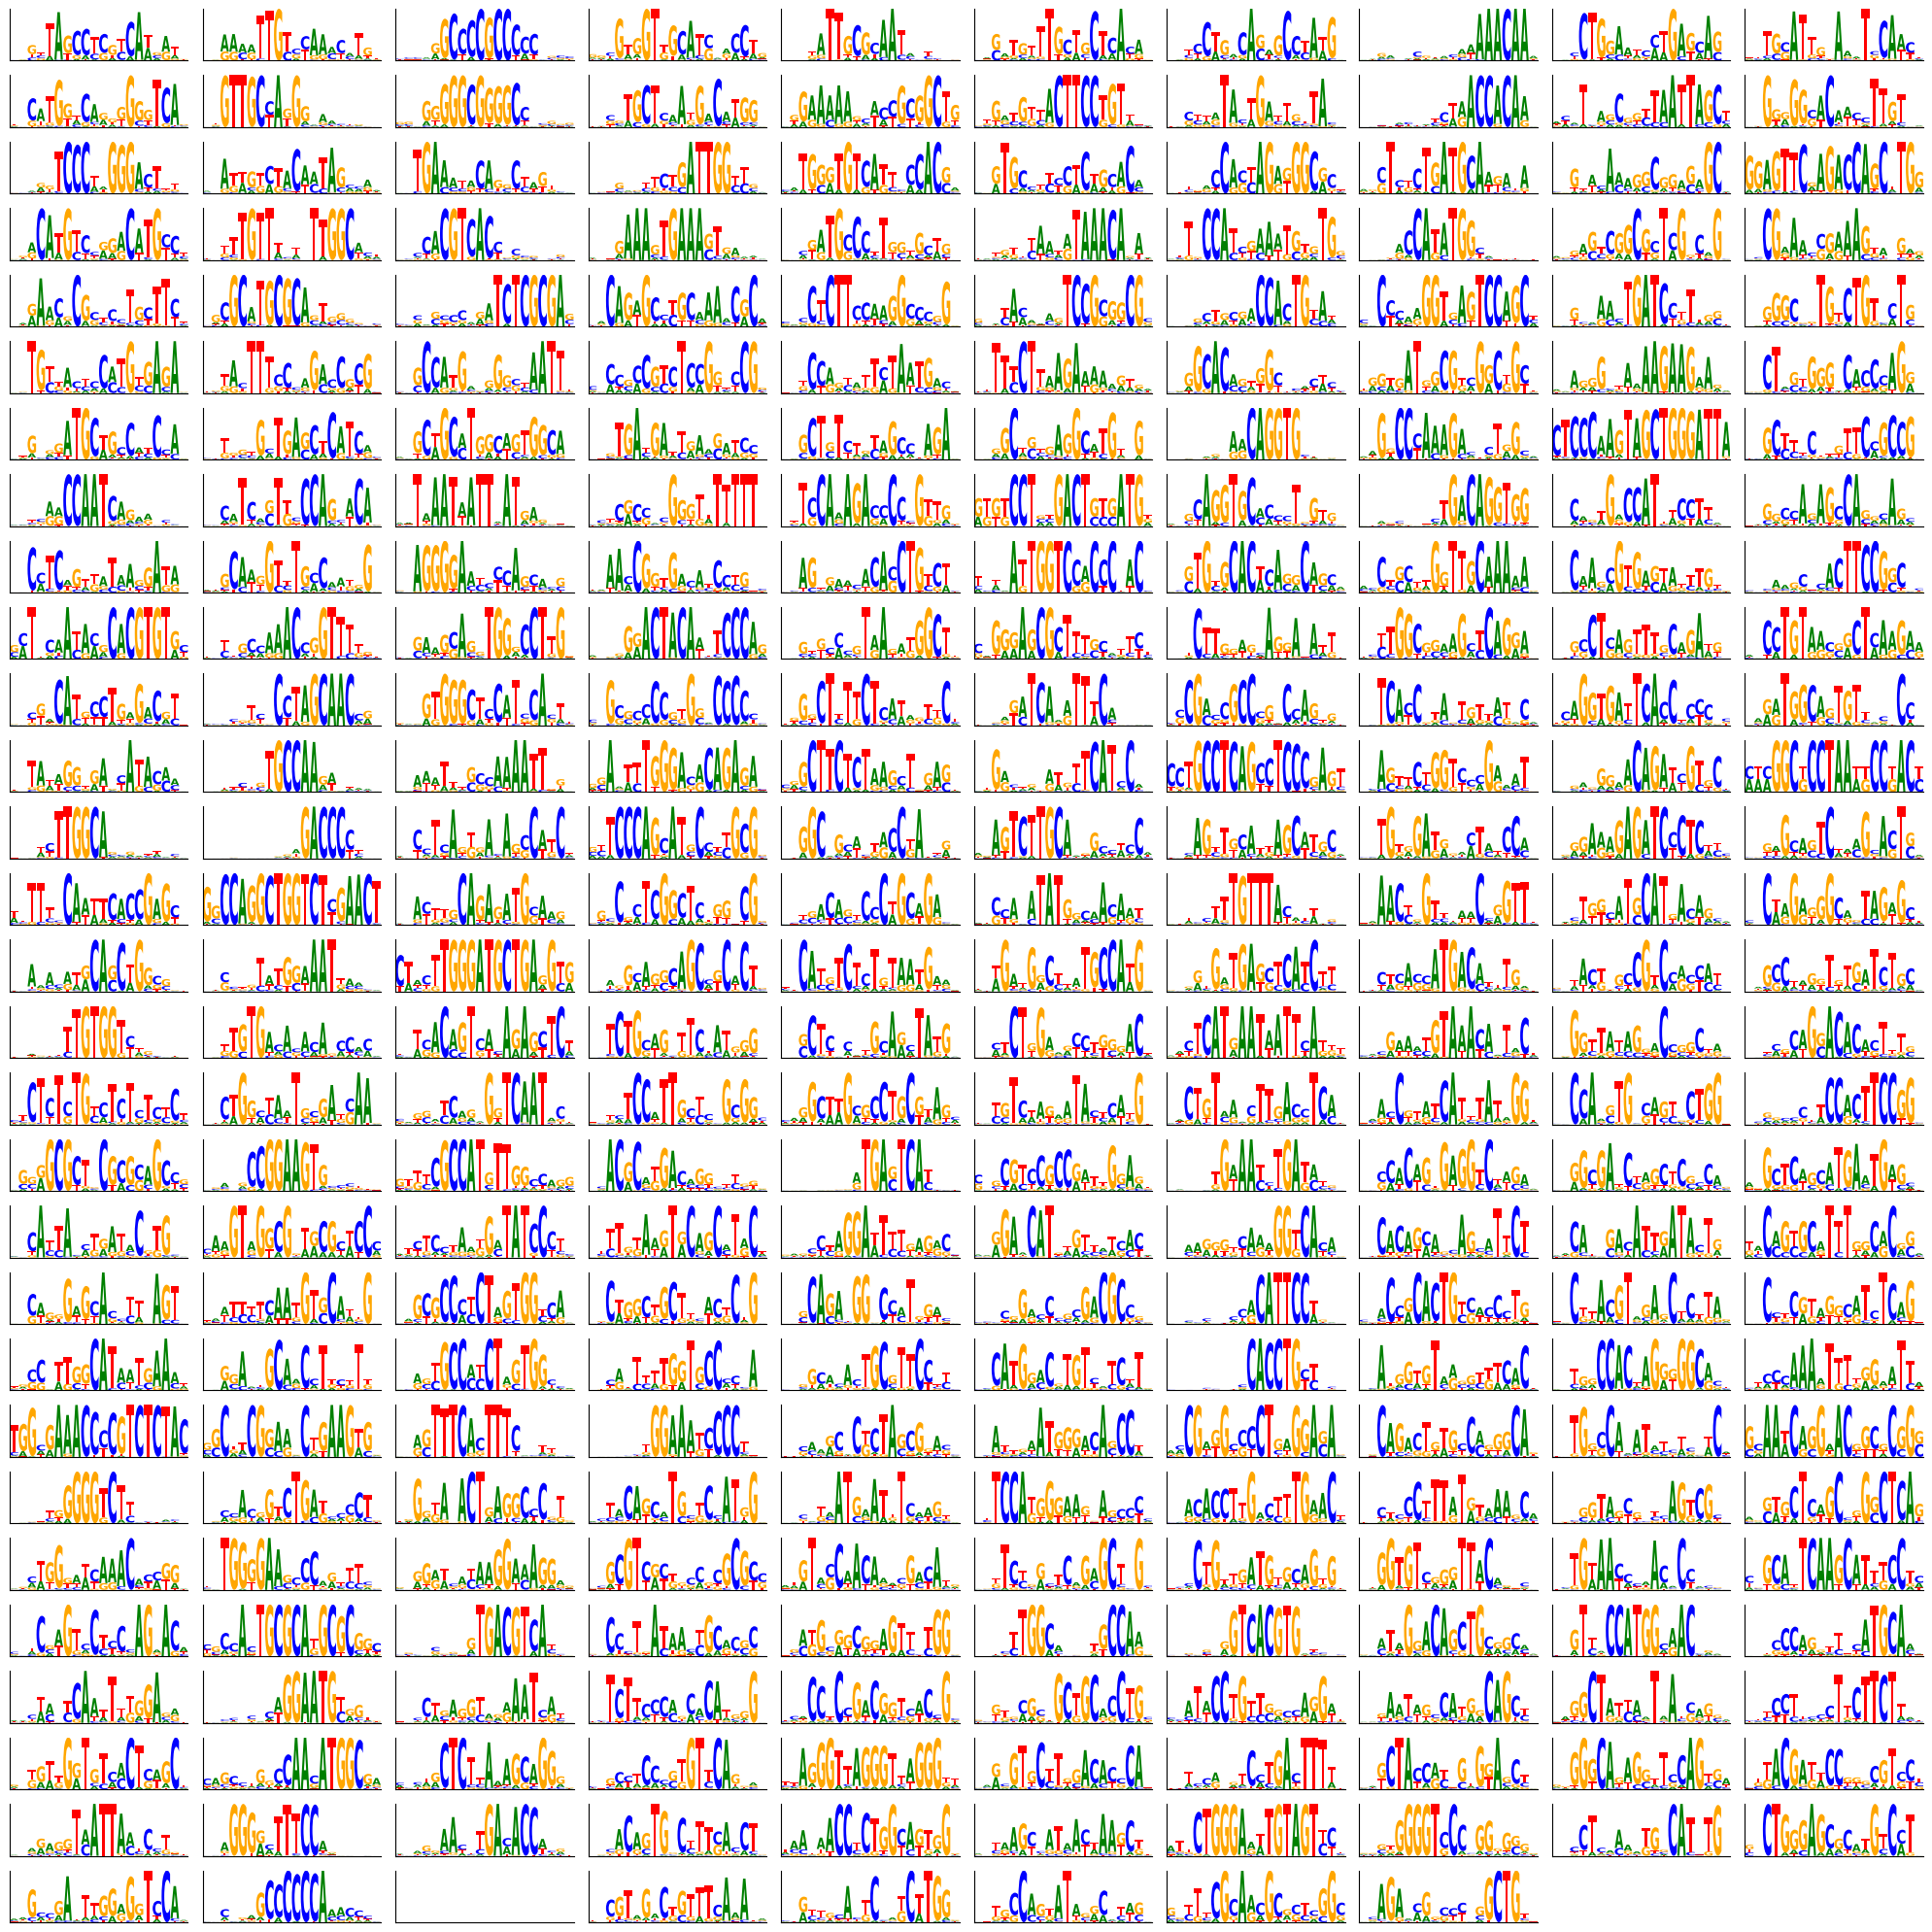

In [ ]:
### Thymus, exp
trained_model = '/home/tianhao/best_models/thymus1_exp_valauc_final_5.h5'
### Change the type of model
model=base_exp((1344, 4))

# compile model
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.95,beta_2=0.9995)
model.compile(loss=loss_fn, optimizer=optimizer,
                  metrics=[tf.keras.metrics.AUC(name='auc', curve='ROC', multi_label=True),
                           tf.keras.metrics.AUC(name='auc_pr', curve='PR', multi_label=True)])
# load model
model.load_weights(trained_model)

W, counts = filter_max_align_batch(x_test, model, layer=6, window=20, threshold=0.5, batch_size=1024, max_align=1e4, verbose=1)
# num_plot = model.layers[5].get_weights()[0].shape[-1]
num_cols = 10
#fig = plt.figure(figsize=(num_plot // num_cols))
fig = plt.figure(figsize=(20,20))
W_df = plot_filters(W, fig, num_cols=num_cols, fontsize=12, names=None, y_labels=None)
fig.savefig('/home/tianhao/Interpretability/firstlayer/thymus_exp.pdf', format='pdf', dpi=200, bbox_inches='tight', transparent=True)

Calculating filter PPM based on activation-based alignments
  Calculating MAX activation


  0%|          | 0/288 [00:00<?, ?it/s]

    processing 1 out of 288 filters


  0%|          | 1/288 [00:05<24:37,  5.15s/it]

      131 sub-sequences above threshold
    processing 2 out of 288 filters


  1%|          | 2/288 [00:10<24:04,  5.05s/it]

      31 sub-sequences above threshold
    processing 3 out of 288 filters


  1%|          | 3/288 [00:16<26:19,  5.54s/it]

      54 sub-sequences above threshold
    processing 4 out of 288 filters


  1%|▏         | 4/288 [00:21<25:41,  5.43s/it]

      112 sub-sequences above threshold
    processing 5 out of 288 filters


  2%|▏         | 5/288 [00:26<25:12,  5.35s/it]

      163 sub-sequences above threshold
    processing 6 out of 288 filters


  2%|▏         | 6/288 [00:31<24:46,  5.27s/it]

      49 sub-sequences above threshold
    processing 7 out of 288 filters


  2%|▏         | 7/288 [00:36<24:23,  5.21s/it]

      118 sub-sequences above threshold
    processing 8 out of 288 filters


  3%|▎         | 8/288 [00:42<24:28,  5.24s/it]

      305 sub-sequences above threshold
    processing 9 out of 288 filters


  3%|▎         | 9/288 [00:47<24:08,  5.19s/it]

      11 sub-sequences above threshold
    processing 10 out of 288 filters


  3%|▎         | 10/288 [00:52<23:49,  5.14s/it]

      27 sub-sequences above threshold
    processing 11 out of 288 filters


  4%|▍         | 11/288 [00:57<23:27,  5.08s/it]

      12 sub-sequences above threshold
    processing 12 out of 288 filters


  4%|▍         | 12/288 [01:02<23:33,  5.12s/it]

      178 sub-sequences above threshold
    processing 13 out of 288 filters


  5%|▍         | 13/288 [01:07<23:25,  5.11s/it]

      234 sub-sequences above threshold
    processing 14 out of 288 filters


  5%|▍         | 14/288 [01:12<23:16,  5.10s/it]

      115 sub-sequences above threshold
    processing 15 out of 288 filters


  5%|▌         | 15/288 [01:17<23:15,  5.11s/it]

      62 sub-sequences above threshold
    processing 16 out of 288 filters


  6%|▌         | 16/288 [01:22<23:10,  5.11s/it]

      28 sub-sequences above threshold
    processing 17 out of 288 filters


  6%|▌         | 17/288 [01:27<23:00,  5.09s/it]

      85 sub-sequences above threshold
    processing 18 out of 288 filters


  6%|▋         | 18/288 [01:32<22:43,  5.05s/it]

      7 sub-sequences above threshold
    processing 19 out of 288 filters


  7%|▋         | 19/288 [01:37<22:29,  5.02s/it]

      23 sub-sequences above threshold
    processing 20 out of 288 filters


  7%|▋         | 20/288 [01:42<22:21,  5.01s/it]

      56 sub-sequences above threshold
    processing 21 out of 288 filters


  7%|▋         | 21/288 [01:47<22:13,  4.99s/it]

      7 sub-sequences above threshold
    processing 22 out of 288 filters


  8%|▊         | 22/288 [01:52<22:10,  5.00s/it]

      110 sub-sequences above threshold
    processing 23 out of 288 filters


  8%|▊         | 23/288 [01:57<21:58,  4.98s/it]

      9 sub-sequences above threshold
    processing 24 out of 288 filters


  8%|▊         | 24/288 [02:02<21:58,  4.99s/it]

      48 sub-sequences above threshold
    processing 25 out of 288 filters


  9%|▊         | 25/288 [02:07<21:49,  4.98s/it]

      26 sub-sequences above threshold
    processing 26 out of 288 filters


  9%|▉         | 26/288 [02:12<21:44,  4.98s/it]

      28 sub-sequences above threshold
    processing 27 out of 288 filters


  9%|▉         | 27/288 [02:17<21:28,  4.94s/it]

      65 sub-sequences above threshold
    processing 28 out of 288 filters


 10%|▉         | 28/288 [02:22<21:32,  4.97s/it]

      69 sub-sequences above threshold
    processing 29 out of 288 filters


 10%|█         | 29/288 [02:27<21:25,  4.96s/it]

      15 sub-sequences above threshold
    processing 30 out of 288 filters


 10%|█         | 30/288 [02:32<21:24,  4.98s/it]

      31 sub-sequences above threshold
    processing 31 out of 288 filters


 11%|█         | 31/288 [02:38<22:06,  5.16s/it]

      1228 sub-sequences above threshold
    processing 32 out of 288 filters


 11%|█         | 32/288 [02:43<21:58,  5.15s/it]

      84 sub-sequences above threshold
    processing 33 out of 288 filters


 11%|█▏        | 33/288 [02:48<21:43,  5.11s/it]

      14 sub-sequences above threshold
    processing 34 out of 288 filters


 12%|█▏        | 34/288 [02:53<21:31,  5.08s/it]

      76 sub-sequences above threshold
    processing 35 out of 288 filters


 12%|█▏        | 35/288 [02:58<21:08,  5.01s/it]

      1 sub-sequences above threshold
    processing 36 out of 288 filters


 12%|█▎        | 36/288 [03:03<21:09,  5.04s/it]

      146 sub-sequences above threshold
    processing 37 out of 288 filters


 13%|█▎        | 37/288 [03:08<21:12,  5.07s/it]

      219 sub-sequences above threshold
    processing 38 out of 288 filters


 13%|█▎        | 38/288 [03:13<21:11,  5.09s/it]

      299 sub-sequences above threshold
    processing 39 out of 288 filters


 14%|█▎        | 39/288 [03:18<20:55,  5.04s/it]

      12 sub-sequences above threshold
    processing 40 out of 288 filters


 14%|█▍        | 40/288 [03:23<20:46,  5.02s/it]

      77 sub-sequences above threshold
    processing 41 out of 288 filters


 14%|█▍        | 41/288 [03:28<20:53,  5.07s/it]

      703 sub-sequences above threshold
    processing 42 out of 288 filters


 15%|█▍        | 42/288 [03:33<20:42,  5.05s/it]

      27 sub-sequences above threshold
    processing 43 out of 288 filters


 15%|█▍        | 43/288 [03:38<20:38,  5.05s/it]

      356 sub-sequences above threshold
    processing 44 out of 288 filters


 15%|█▌        | 44/288 [03:43<20:35,  5.06s/it]

      138 sub-sequences above threshold
    processing 45 out of 288 filters


 16%|█▌        | 45/288 [03:48<20:23,  5.04s/it]

      33 sub-sequences above threshold
    processing 46 out of 288 filters


 16%|█▌        | 46/288 [03:53<20:22,  5.05s/it]

      53 sub-sequences above threshold
    processing 47 out of 288 filters


 16%|█▋        | 47/288 [03:58<20:13,  5.04s/it]

      48 sub-sequences above threshold
    processing 48 out of 288 filters


 17%|█▋        | 48/288 [04:04<20:20,  5.09s/it]

      81 sub-sequences above threshold
    processing 49 out of 288 filters


 17%|█▋        | 49/288 [04:08<20:06,  5.05s/it]

      26 sub-sequences above threshold
    processing 50 out of 288 filters


 17%|█▋        | 50/288 [04:14<20:15,  5.11s/it]

      81 sub-sequences above threshold
    processing 51 out of 288 filters


 18%|█▊        | 51/288 [04:19<20:05,  5.09s/it]

      75 sub-sequences above threshold
    processing 52 out of 288 filters


 18%|█▊        | 52/288 [04:24<20:41,  5.26s/it]

      1526 sub-sequences above threshold
    processing 53 out of 288 filters


 18%|█▊        | 53/288 [04:30<20:28,  5.23s/it]

      73 sub-sequences above threshold
    processing 54 out of 288 filters


 19%|█▉        | 54/288 [04:35<20:18,  5.21s/it]

      96 sub-sequences above threshold
    processing 55 out of 288 filters


 19%|█▉        | 55/288 [04:40<20:03,  5.16s/it]

      46 sub-sequences above threshold
    processing 56 out of 288 filters


 19%|█▉        | 56/288 [04:45<20:16,  5.24s/it]

      54 sub-sequences above threshold
    processing 57 out of 288 filters


 20%|█▉        | 57/288 [04:51<20:22,  5.29s/it]

      367 sub-sequences above threshold
    processing 58 out of 288 filters


 20%|██        | 58/288 [04:56<20:19,  5.30s/it]

      120 sub-sequences above threshold
    processing 59 out of 288 filters


 20%|██        | 59/288 [05:01<20:06,  5.27s/it]

      14 sub-sequences above threshold
    processing 60 out of 288 filters


 21%|██        | 60/288 [05:06<19:45,  5.20s/it]

      87 sub-sequences above threshold
    processing 61 out of 288 filters


 21%|██        | 61/288 [05:11<19:44,  5.22s/it]

      47 sub-sequences above threshold
    processing 62 out of 288 filters


 22%|██▏       | 62/288 [05:17<19:31,  5.18s/it]

      33 sub-sequences above threshold
    processing 63 out of 288 filters


 22%|██▏       | 63/288 [05:22<19:29,  5.20s/it]

      22 sub-sequences above threshold
    processing 64 out of 288 filters


 22%|██▏       | 64/288 [05:27<19:15,  5.16s/it]

      27 sub-sequences above threshold
    processing 65 out of 288 filters


 23%|██▎       | 65/288 [05:32<19:26,  5.23s/it]

      175 sub-sequences above threshold
    processing 66 out of 288 filters


 23%|██▎       | 66/288 [05:37<19:02,  5.15s/it]

      11 sub-sequences above threshold
    processing 67 out of 288 filters


 23%|██▎       | 67/288 [05:42<18:58,  5.15s/it]

      34 sub-sequences above threshold
    processing 68 out of 288 filters


 24%|██▎       | 68/288 [05:48<19:05,  5.21s/it]

      53 sub-sequences above threshold
    processing 69 out of 288 filters


 24%|██▍       | 69/288 [05:53<18:59,  5.20s/it]

      6 sub-sequences above threshold
    processing 70 out of 288 filters


 24%|██▍       | 70/288 [05:58<18:55,  5.21s/it]

      10 sub-sequences above threshold
    processing 71 out of 288 filters


 25%|██▍       | 71/288 [06:03<18:45,  5.19s/it]

      287 sub-sequences above threshold
    processing 72 out of 288 filters


 25%|██▌       | 72/288 [06:09<18:46,  5.22s/it]

      98 sub-sequences above threshold
    processing 73 out of 288 filters


 25%|██▌       | 73/288 [06:14<18:40,  5.21s/it]

      20 sub-sequences above threshold
    processing 74 out of 288 filters


 26%|██▌       | 74/288 [06:19<18:24,  5.16s/it]

      16 sub-sequences above threshold
    processing 75 out of 288 filters


 26%|██▌       | 75/288 [06:24<18:21,  5.17s/it]

      78 sub-sequences above threshold
    processing 76 out of 288 filters


 26%|██▋       | 76/288 [06:29<18:14,  5.16s/it]

      45 sub-sequences above threshold
    processing 77 out of 288 filters


 27%|██▋       | 77/288 [06:34<18:06,  5.15s/it]

      20 sub-sequences above threshold
    processing 78 out of 288 filters


 27%|██▋       | 78/288 [06:39<18:06,  5.17s/it]

      253 sub-sequences above threshold
    processing 79 out of 288 filters


 27%|██▋       | 79/288 [06:45<18:10,  5.22s/it]

      24 sub-sequences above threshold
    processing 80 out of 288 filters


 28%|██▊       | 80/288 [06:50<18:04,  5.22s/it]

      92 sub-sequences above threshold
    processing 81 out of 288 filters


 28%|██▊       | 81/288 [06:55<18:03,  5.23s/it]

      68 sub-sequences above threshold
    processing 82 out of 288 filters


 28%|██▊       | 82/288 [07:00<17:55,  5.22s/it]

      38 sub-sequences above threshold
    processing 83 out of 288 filters


 29%|██▉       | 83/288 [07:06<17:45,  5.20s/it]

      16 sub-sequences above threshold
    processing 84 out of 288 filters


 29%|██▉       | 84/288 [07:11<17:30,  5.15s/it]

      20 sub-sequences above threshold
    processing 85 out of 288 filters


 30%|██▉       | 85/288 [07:16<17:25,  5.15s/it]

      36 sub-sequences above threshold
    processing 86 out of 288 filters


 30%|██▉       | 86/288 [07:21<17:16,  5.13s/it]

      15 sub-sequences above threshold
    processing 87 out of 288 filters


 30%|███       | 87/288 [07:26<17:21,  5.18s/it]

      51 sub-sequences above threshold
    processing 88 out of 288 filters


 31%|███       | 88/288 [07:31<17:09,  5.15s/it]

      102 sub-sequences above threshold
    processing 89 out of 288 filters


 31%|███       | 89/288 [07:37<17:13,  5.20s/it]

      82 sub-sequences above threshold
    processing 90 out of 288 filters


 31%|███▏      | 90/288 [07:42<17:13,  5.22s/it]

      211 sub-sequences above threshold
    processing 91 out of 288 filters


 32%|███▏      | 91/288 [07:47<17:11,  5.24s/it]

      204 sub-sequences above threshold
    processing 92 out of 288 filters


 32%|███▏      | 92/288 [07:52<17:06,  5.24s/it]

      63 sub-sequences above threshold
    processing 93 out of 288 filters


 32%|███▏      | 93/288 [07:58<16:56,  5.21s/it]

      105 sub-sequences above threshold
    processing 94 out of 288 filters


 33%|███▎      | 94/288 [08:03<16:51,  5.21s/it]

      36 sub-sequences above threshold
    processing 95 out of 288 filters


 33%|███▎      | 95/288 [08:08<16:50,  5.24s/it]

      90 sub-sequences above threshold
    processing 96 out of 288 filters


 33%|███▎      | 96/288 [08:13<16:52,  5.27s/it]

      443 sub-sequences above threshold
    processing 97 out of 288 filters


 34%|███▎      | 97/288 [08:18<16:38,  5.23s/it]

      17 sub-sequences above threshold
    processing 98 out of 288 filters


 34%|███▍      | 98/288 [08:24<16:21,  5.16s/it]

      20 sub-sequences above threshold
    processing 99 out of 288 filters


 34%|███▍      | 99/288 [08:29<16:28,  5.23s/it]

      394 sub-sequences above threshold
    processing 100 out of 288 filters


 35%|███▍      | 100/288 [08:34<16:24,  5.24s/it]

      98 sub-sequences above threshold
    processing 101 out of 288 filters


 35%|███▌      | 101/288 [08:39<16:14,  5.21s/it]

      47 sub-sequences above threshold
    processing 102 out of 288 filters


 35%|███▌      | 102/288 [08:44<16:09,  5.21s/it]

      9 sub-sequences above threshold
    processing 103 out of 288 filters


 36%|███▌      | 103/288 [08:50<16:01,  5.20s/it]

      106 sub-sequences above threshold
    processing 104 out of 288 filters


 36%|███▌      | 104/288 [08:55<15:51,  5.17s/it]

      67 sub-sequences above threshold
    processing 105 out of 288 filters


 36%|███▋      | 105/288 [09:00<15:55,  5.22s/it]

      308 sub-sequences above threshold
    processing 106 out of 288 filters


 37%|███▋      | 106/288 [09:05<15:49,  5.22s/it]

      97 sub-sequences above threshold
    processing 107 out of 288 filters


 37%|███▋      | 107/288 [09:11<15:45,  5.22s/it]

      28 sub-sequences above threshold
    processing 108 out of 288 filters


 38%|███▊      | 108/288 [09:16<15:55,  5.31s/it]

      476 sub-sequences above threshold
    processing 109 out of 288 filters


 38%|███▊      | 109/288 [09:21<15:37,  5.24s/it]

      17 sub-sequences above threshold
    processing 110 out of 288 filters


 38%|███▊      | 110/288 [09:26<15:25,  5.20s/it]

      157 sub-sequences above threshold
    processing 111 out of 288 filters


 39%|███▊      | 111/288 [09:31<15:16,  5.18s/it]

      34 sub-sequences above threshold
    processing 112 out of 288 filters


 39%|███▉      | 112/288 [09:37<15:15,  5.20s/it]

      6 sub-sequences above threshold
    processing 113 out of 288 filters


 39%|███▉      | 113/288 [09:42<14:59,  5.14s/it]

      50 sub-sequences above threshold
    processing 114 out of 288 filters


 40%|███▉      | 114/288 [09:47<15:02,  5.18s/it]

      17 sub-sequences above threshold
    processing 115 out of 288 filters


 40%|███▉      | 115/288 [09:52<14:56,  5.18s/it]

      42 sub-sequences above threshold
    processing 116 out of 288 filters


 40%|████      | 116/288 [09:58<15:03,  5.25s/it]

      35 sub-sequences above threshold
    processing 117 out of 288 filters


 41%|████      | 117/288 [10:03<14:53,  5.23s/it]

      13 sub-sequences above threshold
    processing 118 out of 288 filters


 41%|████      | 118/288 [10:08<14:42,  5.19s/it]

      41 sub-sequences above threshold
    processing 119 out of 288 filters


 41%|████▏     | 119/288 [10:13<14:49,  5.27s/it]

      390 sub-sequences above threshold
    processing 120 out of 288 filters


 42%|████▏     | 120/288 [10:18<14:39,  5.24s/it]

      59 sub-sequences above threshold
    processing 121 out of 288 filters


 42%|████▏     | 121/288 [10:24<14:45,  5.30s/it]

      40 sub-sequences above threshold
    processing 122 out of 288 filters


 42%|████▏     | 122/288 [10:29<14:36,  5.28s/it]

      40 sub-sequences above threshold
    processing 123 out of 288 filters


 43%|████▎     | 123/288 [10:34<14:29,  5.27s/it]

      48 sub-sequences above threshold
    processing 124 out of 288 filters


 43%|████▎     | 124/288 [10:39<14:17,  5.23s/it]

      7 sub-sequences above threshold
    processing 125 out of 288 filters


 43%|████▎     | 125/288 [10:45<14:19,  5.27s/it]

      42 sub-sequences above threshold
    processing 126 out of 288 filters


 44%|████▍     | 126/288 [10:50<14:22,  5.32s/it]

      103 sub-sequences above threshold
    processing 127 out of 288 filters


 44%|████▍     | 127/288 [10:56<14:14,  5.31s/it]

      60 sub-sequences above threshold
    processing 128 out of 288 filters


 44%|████▍     | 128/288 [11:01<14:13,  5.34s/it]

      31 sub-sequences above threshold
    processing 129 out of 288 filters


 45%|████▍     | 129/288 [11:06<14:08,  5.34s/it]

      75 sub-sequences above threshold
    processing 130 out of 288 filters


 45%|████▌     | 130/288 [11:11<13:50,  5.26s/it]

      33 sub-sequences above threshold
    processing 131 out of 288 filters


 45%|████▌     | 131/288 [11:17<13:52,  5.30s/it]

      212 sub-sequences above threshold
    processing 132 out of 288 filters


 46%|████▌     | 132/288 [11:22<13:53,  5.34s/it]

      40 sub-sequences above threshold
    processing 133 out of 288 filters


 46%|████▌     | 133/288 [11:27<13:45,  5.33s/it]

      32 sub-sequences above threshold
    processing 134 out of 288 filters


 47%|████▋     | 134/288 [11:33<13:34,  5.29s/it]

      25 sub-sequences above threshold
    processing 135 out of 288 filters


 47%|████▋     | 135/288 [11:38<13:31,  5.30s/it]

      285 sub-sequences above threshold
    processing 136 out of 288 filters


 47%|████▋     | 136/288 [11:43<13:27,  5.31s/it]

      28 sub-sequences above threshold
    processing 137 out of 288 filters


 48%|████▊     | 137/288 [11:49<13:21,  5.31s/it]

      20 sub-sequences above threshold
    processing 138 out of 288 filters


 48%|████▊     | 138/288 [11:54<13:27,  5.38s/it]

      339 sub-sequences above threshold
    processing 139 out of 288 filters


 48%|████▊     | 139/288 [12:00<13:17,  5.35s/it]

      70 sub-sequences above threshold
    processing 140 out of 288 filters


 49%|████▊     | 140/288 [12:05<13:15,  5.38s/it]

      243 sub-sequences above threshold
    processing 141 out of 288 filters


 49%|████▉     | 141/288 [12:10<12:35,  5.14s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 142 out of 288 filters


 49%|████▉     | 142/288 [12:15<12:32,  5.15s/it]

      219 sub-sequences above threshold
    processing 143 out of 288 filters


 50%|████▉     | 143/288 [12:20<12:27,  5.16s/it]

      12 sub-sequences above threshold
    processing 144 out of 288 filters


 50%|█████     | 144/288 [12:24<11:55,  4.97s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 145 out of 288 filters


 50%|█████     | 145/288 [12:32<13:43,  5.76s/it]

      82 sub-sequences above threshold
    processing 146 out of 288 filters


 51%|█████     | 146/288 [12:36<12:37,  5.34s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 147 out of 288 filters


 51%|█████     | 147/288 [12:41<12:13,  5.20s/it]

      22 sub-sequences above threshold
    processing 148 out of 288 filters


 51%|█████▏    | 148/288 [12:47<12:23,  5.31s/it]

      1588 sub-sequences above threshold
    processing 149 out of 288 filters


 52%|█████▏    | 149/288 [12:52<11:55,  5.15s/it]

      15 sub-sequences above threshold
    processing 150 out of 288 filters


 52%|█████▏    | 150/288 [12:57<11:45,  5.12s/it]

      11 sub-sequences above threshold
    processing 151 out of 288 filters


 52%|█████▏    | 151/288 [13:01<11:29,  5.03s/it]

      24 sub-sequences above threshold
    processing 152 out of 288 filters


 53%|█████▎    | 152/288 [13:06<11:18,  4.99s/it]

      18 sub-sequences above threshold
    processing 153 out of 288 filters


 53%|█████▎    | 153/288 [13:12<11:27,  5.09s/it]

      89 sub-sequences above threshold
    processing 154 out of 288 filters


 53%|█████▎    | 154/288 [13:17<11:15,  5.04s/it]

      13 sub-sequences above threshold
    processing 155 out of 288 filters


 54%|█████▍    | 155/288 [13:21<10:53,  4.92s/it]

      10 sub-sequences above threshold
    processing 156 out of 288 filters


 54%|█████▍    | 156/288 [13:26<10:54,  4.96s/it]

      204 sub-sequences above threshold
    processing 157 out of 288 filters


 55%|█████▍    | 157/288 [13:31<10:42,  4.91s/it]

      36 sub-sequences above threshold
    processing 158 out of 288 filters


 55%|█████▍    | 158/288 [13:36<10:48,  4.99s/it]

      210 sub-sequences above threshold
    processing 159 out of 288 filters


 55%|█████▌    | 159/288 [13:41<10:40,  4.96s/it]

      32 sub-sequences above threshold
    processing 160 out of 288 filters


 56%|█████▌    | 160/288 [13:46<10:28,  4.91s/it]

      48 sub-sequences above threshold
    processing 161 out of 288 filters


 56%|█████▌    | 161/288 [13:51<10:28,  4.95s/it]

      148 sub-sequences above threshold
    processing 162 out of 288 filters


 56%|█████▋    | 162/288 [13:56<10:26,  4.97s/it]

      34 sub-sequences above threshold
    processing 163 out of 288 filters


 57%|█████▋    | 163/288 [14:01<10:26,  5.02s/it]

      48 sub-sequences above threshold
    processing 164 out of 288 filters


 57%|█████▋    | 164/288 [14:06<10:27,  5.06s/it]

      188 sub-sequences above threshold
    processing 165 out of 288 filters


 57%|█████▋    | 165/288 [14:11<10:18,  5.03s/it]

      138 sub-sequences above threshold
    processing 166 out of 288 filters


 58%|█████▊    | 166/288 [14:16<10:15,  5.04s/it]

      279 sub-sequences above threshold
    processing 167 out of 288 filters


 58%|█████▊    | 167/288 [14:22<10:19,  5.12s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 168 out of 288 filters


 58%|█████▊    | 168/288 [14:27<10:10,  5.09s/it]

      160 sub-sequences above threshold
    processing 169 out of 288 filters


 59%|█████▊    | 169/288 [14:32<10:00,  5.05s/it]

      9 sub-sequences above threshold
    processing 170 out of 288 filters


 59%|█████▉    | 170/288 [14:37<09:53,  5.03s/it]

      62 sub-sequences above threshold
    processing 171 out of 288 filters


 59%|█████▉    | 171/288 [14:42<09:53,  5.07s/it]

      132 sub-sequences above threshold
    processing 172 out of 288 filters


 60%|█████▉    | 172/288 [14:47<09:41,  5.02s/it]

      166 sub-sequences above threshold
    processing 173 out of 288 filters


 60%|██████    | 173/288 [14:52<09:32,  4.98s/it]

      32 sub-sequences above threshold
    processing 174 out of 288 filters


 60%|██████    | 174/288 [14:57<09:30,  5.00s/it]

      66 sub-sequences above threshold
    processing 175 out of 288 filters


 61%|██████    | 175/288 [15:02<09:33,  5.08s/it]

      23 sub-sequences above threshold
    processing 176 out of 288 filters


 61%|██████    | 176/288 [15:08<10:01,  5.37s/it]

      2776 sub-sequences above threshold
    processing 177 out of 288 filters


 61%|██████▏   | 177/288 [15:13<09:47,  5.30s/it]

      40 sub-sequences above threshold
    processing 178 out of 288 filters


 62%|██████▏   | 178/288 [15:18<09:32,  5.21s/it]

      5 sub-sequences above threshold
    processing 179 out of 288 filters


 62%|██████▏   | 179/288 [15:23<09:25,  5.19s/it]

      384 sub-sequences above threshold
    processing 180 out of 288 filters


 62%|██████▎   | 180/288 [15:28<09:08,  5.07s/it]

      92 sub-sequences above threshold
    processing 181 out of 288 filters


 63%|██████▎   | 181/288 [15:33<09:01,  5.06s/it]

      22 sub-sequences above threshold
    processing 182 out of 288 filters


 63%|██████▎   | 182/288 [15:38<08:59,  5.09s/it]

      107 sub-sequences above threshold
    processing 183 out of 288 filters


 64%|██████▎   | 183/288 [15:43<08:59,  5.14s/it]

      97 sub-sequences above threshold
    processing 184 out of 288 filters


 64%|██████▍   | 184/288 [15:49<08:58,  5.17s/it]

      197 sub-sequences above threshold
    processing 185 out of 288 filters


 64%|██████▍   | 185/288 [15:55<09:22,  5.46s/it]

      2712 sub-sequences above threshold
    processing 186 out of 288 filters


 65%|██████▍   | 186/288 [16:00<09:05,  5.35s/it]

      239 sub-sequences above threshold
    processing 187 out of 288 filters


 65%|██████▍   | 187/288 [16:05<08:50,  5.25s/it]

      51 sub-sequences above threshold
    processing 188 out of 288 filters


 65%|██████▌   | 188/288 [16:10<08:40,  5.21s/it]

      18 sub-sequences above threshold
    processing 189 out of 288 filters


 66%|██████▌   | 189/288 [16:15<08:27,  5.13s/it]

      97 sub-sequences above threshold
    processing 190 out of 288 filters


 66%|██████▌   | 190/288 [16:20<08:17,  5.08s/it]

      79 sub-sequences above threshold
    processing 191 out of 288 filters


 66%|██████▋   | 191/288 [16:25<08:12,  5.08s/it]

      94 sub-sequences above threshold
    processing 192 out of 288 filters


 67%|██████▋   | 192/288 [16:30<08:11,  5.12s/it]

      128 sub-sequences above threshold
    processing 193 out of 288 filters


 67%|██████▋   | 193/288 [16:35<07:59,  5.05s/it]

      15 sub-sequences above threshold
    processing 194 out of 288 filters


 67%|██████▋   | 194/288 [16:40<07:50,  5.01s/it]

      6 sub-sequences above threshold
    processing 195 out of 288 filters


 68%|██████▊   | 195/288 [16:45<07:45,  5.01s/it]

      78 sub-sequences above threshold
    processing 196 out of 288 filters


 68%|██████▊   | 196/288 [16:50<07:45,  5.06s/it]

      327 sub-sequences above threshold
    processing 197 out of 288 filters


 68%|██████▊   | 197/288 [16:55<07:38,  5.04s/it]

      13 sub-sequences above threshold
    processing 198 out of 288 filters


 69%|██████▉   | 198/288 [17:00<07:32,  5.03s/it]

      142 sub-sequences above threshold
    processing 199 out of 288 filters


 69%|██████▉   | 199/288 [17:05<07:31,  5.07s/it]

      65 sub-sequences above threshold
    processing 200 out of 288 filters


 69%|██████▉   | 200/288 [17:10<07:25,  5.06s/it]

      136 sub-sequences above threshold
    processing 201 out of 288 filters


 70%|██████▉   | 201/288 [17:15<07:16,  5.02s/it]

      53 sub-sequences above threshold
    processing 202 out of 288 filters


 70%|███████   | 202/288 [17:20<07:08,  4.99s/it]

      116 sub-sequences above threshold
    processing 203 out of 288 filters


 70%|███████   | 203/288 [17:25<07:02,  4.98s/it]

      77 sub-sequences above threshold
    processing 204 out of 288 filters


 71%|███████   | 204/288 [17:30<06:58,  4.98s/it]

      57 sub-sequences above threshold
    processing 205 out of 288 filters


 71%|███████   | 205/288 [17:35<06:53,  4.99s/it]

      128 sub-sequences above threshold
    processing 206 out of 288 filters


 72%|███████▏  | 206/288 [17:40<06:49,  4.99s/it]

      71 sub-sequences above threshold
    processing 207 out of 288 filters


 72%|███████▏  | 207/288 [17:45<06:48,  5.04s/it]

      463 sub-sequences above threshold
    processing 208 out of 288 filters


 72%|███████▏  | 208/288 [17:50<06:40,  5.01s/it]

      101 sub-sequences above threshold
    processing 209 out of 288 filters


 73%|███████▎  | 209/288 [17:55<06:37,  5.03s/it]

      64 sub-sequences above threshold
    processing 210 out of 288 filters


 73%|███████▎  | 210/288 [18:01<06:36,  5.08s/it]

      253 sub-sequences above threshold
    processing 211 out of 288 filters


 73%|███████▎  | 211/288 [18:06<06:30,  5.07s/it]

      73 sub-sequences above threshold
    processing 212 out of 288 filters


 74%|███████▎  | 212/288 [18:11<06:26,  5.09s/it]

      313 sub-sequences above threshold
    processing 213 out of 288 filters


 74%|███████▍  | 213/288 [18:16<06:17,  5.03s/it]

      10 sub-sequences above threshold
    processing 214 out of 288 filters


 74%|███████▍  | 214/288 [18:20<06:08,  4.99s/it]

      34 sub-sequences above threshold
    processing 215 out of 288 filters


 75%|███████▍  | 215/288 [18:26<06:07,  5.03s/it]

      34 sub-sequences above threshold
    processing 216 out of 288 filters


 75%|███████▌  | 216/288 [18:31<06:03,  5.05s/it]

      67 sub-sequences above threshold
    processing 217 out of 288 filters


 75%|███████▌  | 217/288 [18:36<06:00,  5.07s/it]

      89 sub-sequences above threshold
    processing 218 out of 288 filters


 76%|███████▌  | 218/288 [18:41<05:56,  5.10s/it]

      50 sub-sequences above threshold
    processing 219 out of 288 filters


 76%|███████▌  | 219/288 [18:46<05:46,  5.03s/it]

      20 sub-sequences above threshold
    processing 220 out of 288 filters


 76%|███████▋  | 220/288 [18:51<05:39,  4.99s/it]

      28 sub-sequences above threshold
    processing 221 out of 288 filters


 77%|███████▋  | 221/288 [18:56<05:30,  4.94s/it]

      7 sub-sequences above threshold
    processing 222 out of 288 filters


 77%|███████▋  | 222/288 [19:01<05:30,  5.01s/it]

      364 sub-sequences above threshold
    processing 223 out of 288 filters


 77%|███████▋  | 223/288 [19:06<05:26,  5.02s/it]

      28 sub-sequences above threshold
    processing 224 out of 288 filters


 78%|███████▊  | 224/288 [19:11<05:23,  5.05s/it]

      305 sub-sequences above threshold
    processing 225 out of 288 filters


 78%|███████▊  | 225/288 [19:16<05:15,  5.00s/it]

      10 sub-sequences above threshold
    processing 226 out of 288 filters


 78%|███████▊  | 226/288 [19:21<05:12,  5.05s/it]

      87 sub-sequences above threshold
    processing 227 out of 288 filters


 79%|███████▉  | 227/288 [19:26<05:05,  5.00s/it]

      30 sub-sequences above threshold
    processing 228 out of 288 filters


 79%|███████▉  | 228/288 [19:31<04:58,  4.98s/it]

      19 sub-sequences above threshold
    processing 229 out of 288 filters


 80%|███████▉  | 229/288 [19:36<04:57,  5.04s/it]

      58 sub-sequences above threshold
    processing 230 out of 288 filters


 80%|███████▉  | 230/288 [19:41<04:55,  5.10s/it]

      52 sub-sequences above threshold
    processing 231 out of 288 filters


 80%|████████  | 231/288 [19:47<04:55,  5.19s/it]

      785 sub-sequences above threshold
    processing 232 out of 288 filters


 81%|████████  | 232/288 [19:52<04:51,  5.20s/it]

      224 sub-sequences above threshold
    processing 233 out of 288 filters


 81%|████████  | 233/288 [19:57<04:44,  5.17s/it]

      115 sub-sequences above threshold
    processing 234 out of 288 filters


 81%|████████▏ | 234/288 [20:02<04:37,  5.13s/it]

      49 sub-sequences above threshold
    processing 235 out of 288 filters


 82%|████████▏ | 235/288 [20:07<04:32,  5.13s/it]

      23 sub-sequences above threshold
    processing 236 out of 288 filters


 82%|████████▏ | 236/288 [20:13<04:38,  5.35s/it]

      1913 sub-sequences above threshold
    processing 237 out of 288 filters


 82%|████████▏ | 237/288 [20:18<04:28,  5.26s/it]

      76 sub-sequences above threshold
    processing 238 out of 288 filters


 83%|████████▎ | 238/288 [20:23<04:19,  5.18s/it]

      21 sub-sequences above threshold
    processing 239 out of 288 filters


 83%|████████▎ | 239/288 [20:28<04:12,  5.15s/it]

      44 sub-sequences above threshold
    processing 240 out of 288 filters


 83%|████████▎ | 240/288 [20:33<04:03,  5.07s/it]

      53 sub-sequences above threshold
    processing 241 out of 288 filters


 84%|████████▎ | 241/288 [20:38<03:56,  5.02s/it]

      23 sub-sequences above threshold
    processing 242 out of 288 filters


 84%|████████▍ | 242/288 [20:43<03:48,  4.96s/it]

      27 sub-sequences above threshold
    processing 243 out of 288 filters


 84%|████████▍ | 243/288 [20:48<03:44,  4.99s/it]

      575 sub-sequences above threshold
    processing 244 out of 288 filters


 85%|████████▍ | 244/288 [20:53<03:40,  5.02s/it]

      192 sub-sequences above threshold
    processing 245 out of 288 filters


 85%|████████▌ | 245/288 [20:58<03:37,  5.05s/it]

      125 sub-sequences above threshold
    processing 246 out of 288 filters


 85%|████████▌ | 246/288 [21:03<03:30,  5.01s/it]

      27 sub-sequences above threshold
    processing 247 out of 288 filters


 86%|████████▌ | 247/288 [21:08<03:26,  5.03s/it]

      227 sub-sequences above threshold
    processing 248 out of 288 filters


 86%|████████▌ | 248/288 [21:13<03:19,  4.99s/it]

      40 sub-sequences above threshold
    processing 249 out of 288 filters


 86%|████████▋ | 249/288 [21:18<03:15,  5.02s/it]

      354 sub-sequences above threshold
    processing 250 out of 288 filters


 87%|████████▋ | 250/288 [21:23<03:10,  5.02s/it]

      71 sub-sequences above threshold
    processing 251 out of 288 filters


 87%|████████▋ | 251/288 [21:28<03:06,  5.04s/it]

      66 sub-sequences above threshold
    processing 252 out of 288 filters


 88%|████████▊ | 252/288 [21:33<02:58,  4.96s/it]

      27 sub-sequences above threshold
    processing 253 out of 288 filters


 88%|████████▊ | 253/288 [21:38<02:53,  4.96s/it]

      80 sub-sequences above threshold
    processing 254 out of 288 filters


 88%|████████▊ | 254/288 [21:43<02:49,  4.97s/it]

      40 sub-sequences above threshold
    processing 255 out of 288 filters


 89%|████████▊ | 255/288 [21:48<02:43,  4.95s/it]

      19 sub-sequences above threshold
    processing 256 out of 288 filters


 89%|████████▉ | 256/288 [21:53<02:38,  4.94s/it]

      39 sub-sequences above threshold
    processing 257 out of 288 filters


 89%|████████▉ | 257/288 [21:57<02:32,  4.91s/it]

      38 sub-sequences above threshold
    processing 258 out of 288 filters


 90%|████████▉ | 258/288 [22:02<02:26,  4.88s/it]

      72 sub-sequences above threshold
    processing 259 out of 288 filters


 90%|████████▉ | 259/288 [22:07<02:24,  4.97s/it]

      40 sub-sequences above threshold
    processing 260 out of 288 filters


 90%|█████████ | 260/288 [22:12<02:19,  4.97s/it]

      16 sub-sequences above threshold
    processing 261 out of 288 filters


 91%|█████████ | 261/288 [22:17<02:13,  4.96s/it]

      20 sub-sequences above threshold
    processing 262 out of 288 filters


 91%|█████████ | 262/288 [22:22<02:08,  4.94s/it]

      33 sub-sequences above threshold
    processing 263 out of 288 filters


 91%|█████████▏| 263/288 [22:27<02:03,  4.94s/it]

      38 sub-sequences above threshold
    processing 264 out of 288 filters


 92%|█████████▏| 264/288 [22:32<01:58,  4.92s/it]

      170 sub-sequences above threshold
    processing 265 out of 288 filters


 92%|█████████▏| 265/288 [22:37<01:52,  4.90s/it]

      90 sub-sequences above threshold
    processing 266 out of 288 filters


 92%|█████████▏| 266/288 [22:42<01:47,  4.90s/it]

      170 sub-sequences above threshold
    processing 267 out of 288 filters


 93%|█████████▎| 267/288 [22:47<01:43,  4.91s/it]

      243 sub-sequences above threshold
    processing 268 out of 288 filters


 93%|█████████▎| 268/288 [22:52<01:38,  4.92s/it]

      64 sub-sequences above threshold
    processing 269 out of 288 filters


 93%|█████████▎| 269/288 [22:56<01:32,  4.88s/it]

      101 sub-sequences above threshold
    processing 270 out of 288 filters


 94%|█████████▍| 270/288 [23:01<01:27,  4.86s/it]

      27 sub-sequences above threshold
    processing 271 out of 288 filters


 94%|█████████▍| 271/288 [23:06<01:22,  4.83s/it]

      32 sub-sequences above threshold
    processing 272 out of 288 filters


 94%|█████████▍| 272/288 [23:11<01:17,  4.84s/it]

      95 sub-sequences above threshold
    processing 273 out of 288 filters


 95%|█████████▍| 273/288 [23:16<01:12,  4.80s/it]

      1 sub-sequences above threshold
    processing 274 out of 288 filters


 95%|█████████▌| 274/288 [23:21<01:09,  4.95s/it]

      1061 sub-sequences above threshold
    processing 275 out of 288 filters


 95%|█████████▌| 275/288 [23:26<01:03,  4.91s/it]

      41 sub-sequences above threshold
    processing 276 out of 288 filters


 96%|█████████▌| 276/288 [23:32<01:02,  5.19s/it]

      2355 sub-sequences above threshold
    processing 277 out of 288 filters


 96%|█████████▌| 277/288 [23:37<00:56,  5.14s/it]

      26 sub-sequences above threshold
    processing 278 out of 288 filters


 97%|█████████▋| 278/288 [23:42<00:51,  5.15s/it]

      134 sub-sequences above threshold
    processing 279 out of 288 filters


 97%|█████████▋| 279/288 [23:47<00:46,  5.18s/it]

      258 sub-sequences above threshold
    processing 280 out of 288 filters


 97%|█████████▋| 280/288 [23:52<00:41,  5.16s/it]

      65 sub-sequences above threshold
    processing 281 out of 288 filters


 98%|█████████▊| 281/288 [23:57<00:35,  5.13s/it]

      21 sub-sequences above threshold
    processing 282 out of 288 filters


 98%|█████████▊| 282/288 [24:02<00:30,  5.12s/it]

      74 sub-sequences above threshold
    processing 283 out of 288 filters


 98%|█████████▊| 283/288 [24:08<00:25,  5.17s/it]

      196 sub-sequences above threshold
    processing 284 out of 288 filters


 99%|█████████▊| 284/288 [24:13<00:20,  5.11s/it]

      7 sub-sequences above threshold
    processing 285 out of 288 filters


 99%|█████████▉| 285/288 [24:18<00:15,  5.09s/it]

      55 sub-sequences above threshold
    processing 286 out of 288 filters


 99%|█████████▉| 286/288 [24:25<00:11,  5.73s/it]

      30 sub-sequences above threshold
    processing 287 out of 288 filters


100%|█████████▉| 287/288 [24:30<00:05,  5.49s/it]

      13 sub-sequences above threshold
    processing 288 out of 288 filters


100%|██████████| 288/288 [24:35<00:00,  5.12s/it]

      135 sub-sequences above threshold


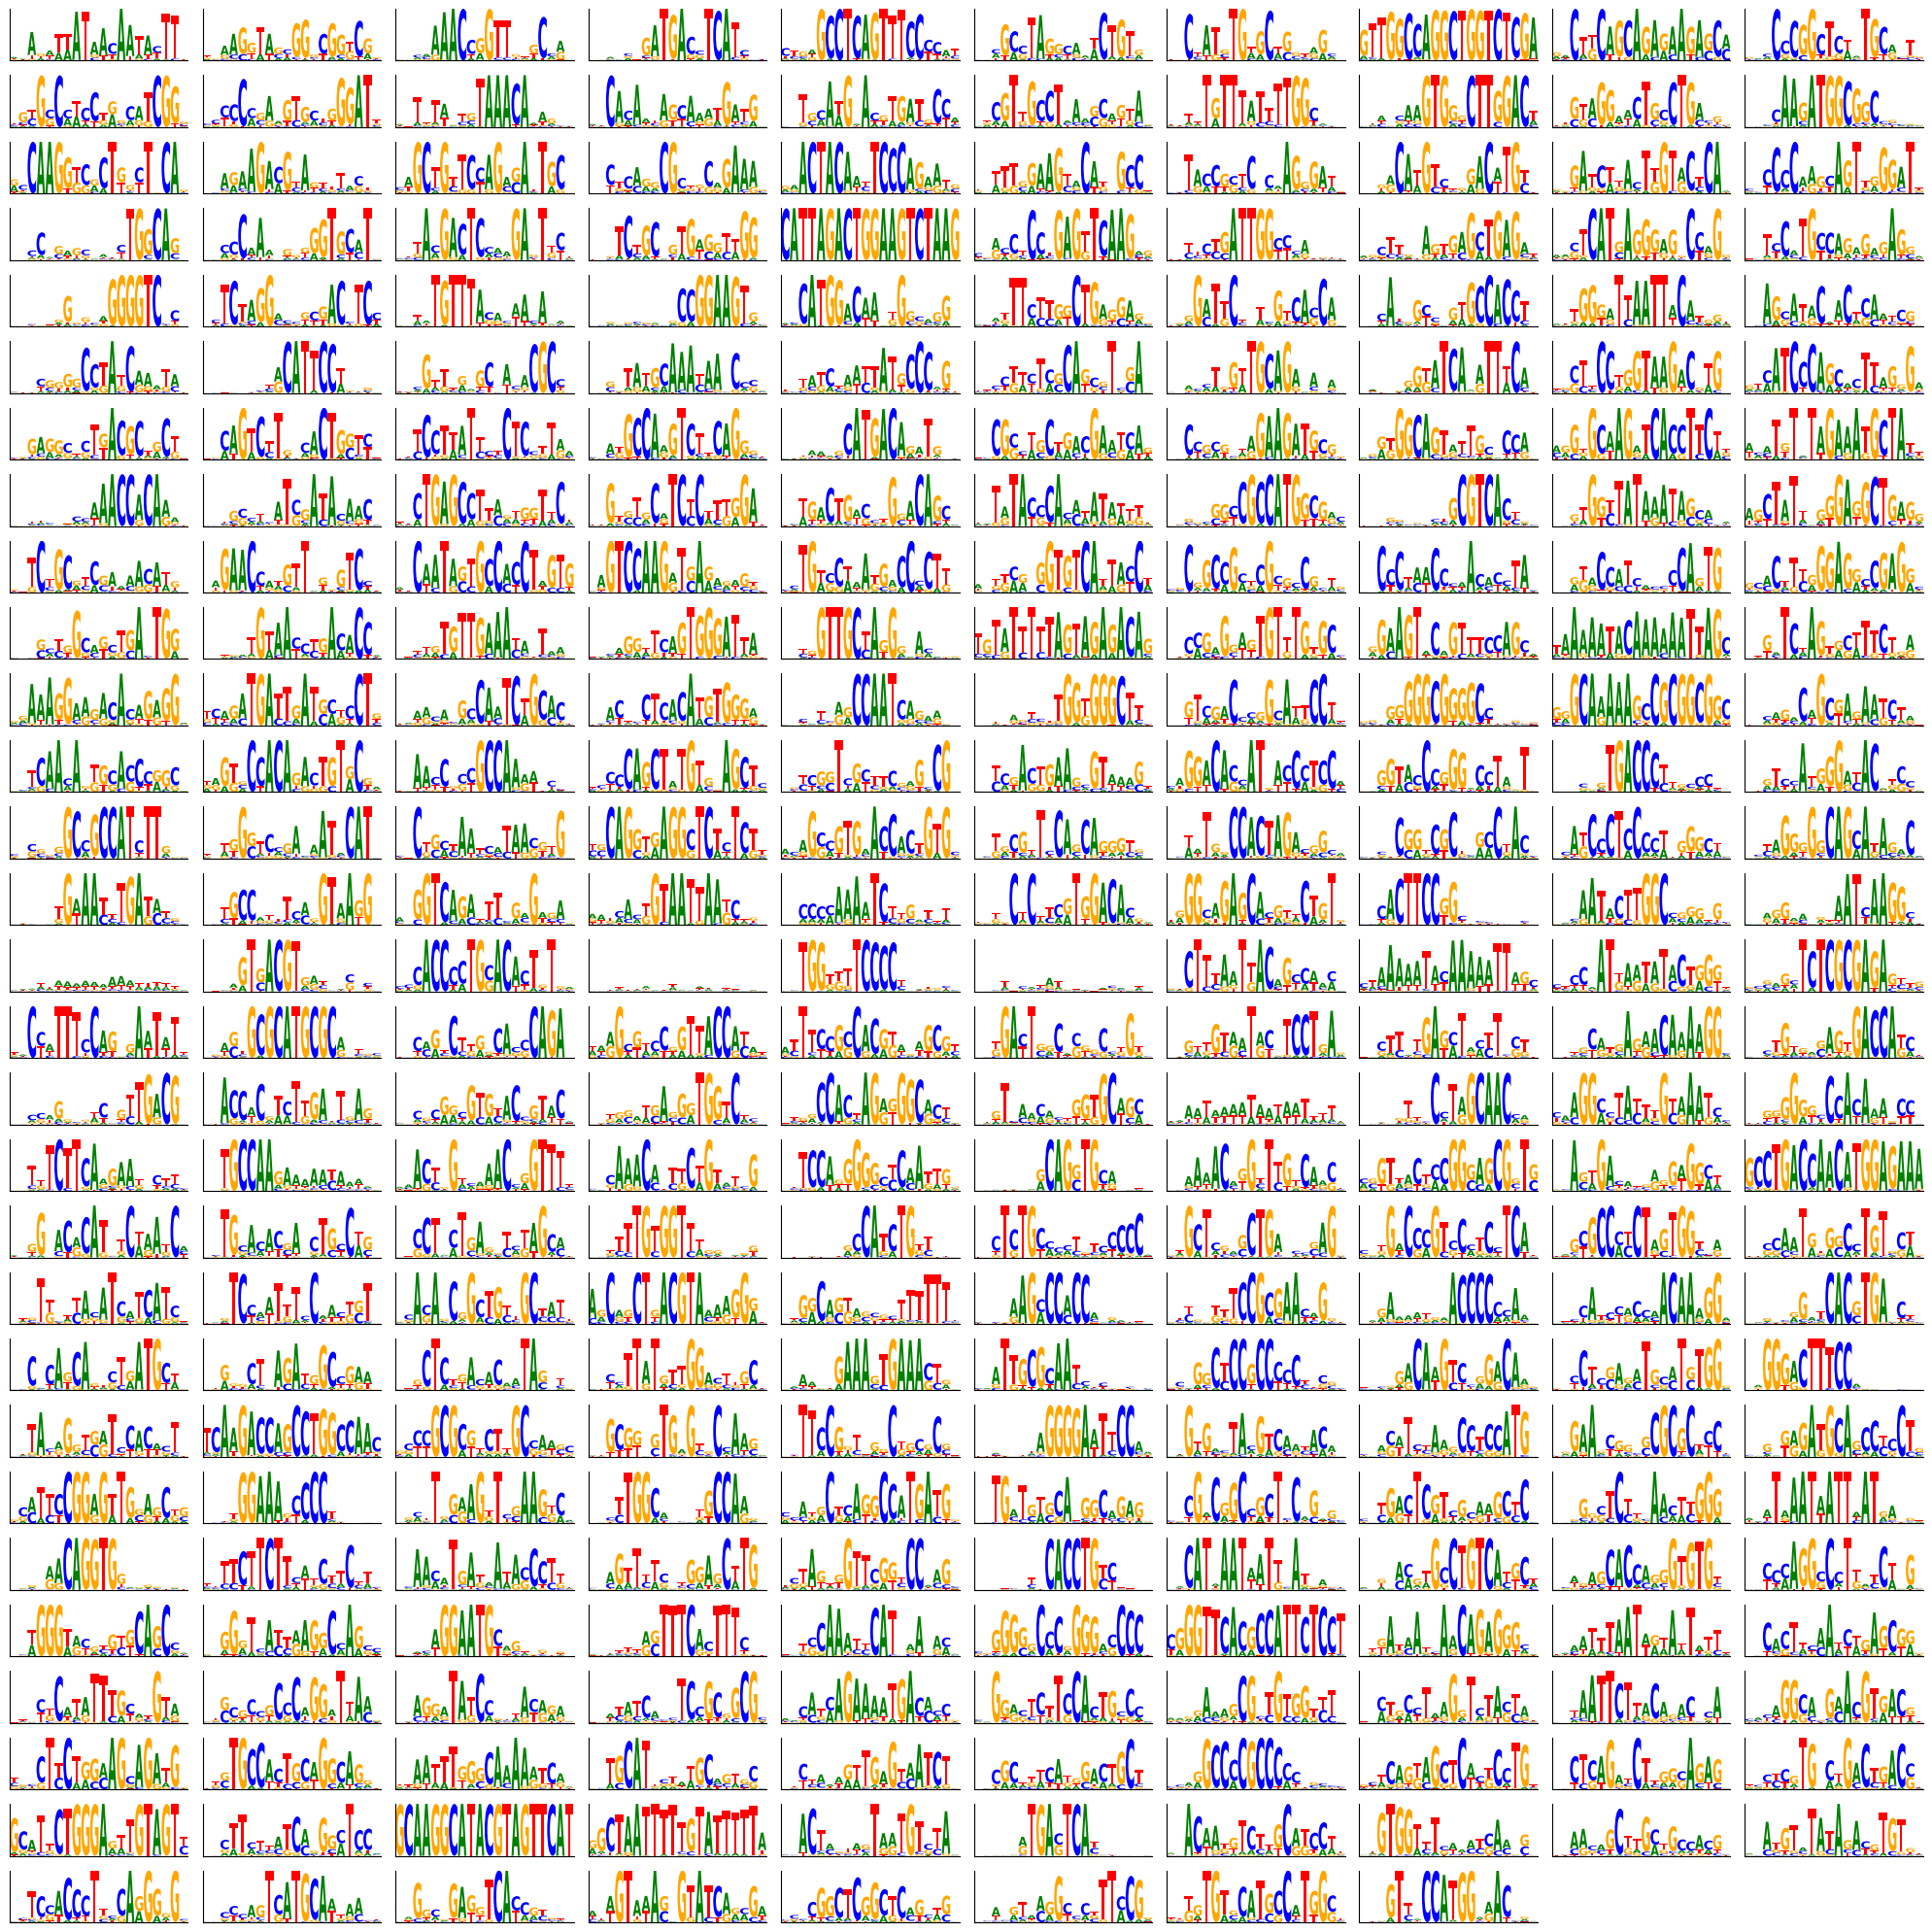

In [ ]:
### Thymus, exp
trained_model = '/home/tianhao/best_models/thymus1_exp_0729.h5'
### Change the type of model
model=base_exp((1344, 4))

# compile model
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.95,beta_2=0.9995)
model.compile(loss=loss_fn, optimizer=optimizer,
                  metrics=[tf.keras.metrics.AUC(name='auc', curve='ROC', multi_label=True),
                           tf.keras.metrics.AUC(name='auc_pr', curve='PR', multi_label=True)])
# load model
model.load_weights(trained_model)

W, counts = filter_max_align_batch(x_test, model, layer=6, window=20, threshold=0.5, batch_size=1024, max_align=1e4, verbose=1)
# num_plot = model.layers[5].get_weights()[0].shape[-1]
num_cols = 10
#fig = plt.figure(figsize=(num_plot // num_cols))
fig = plt.figure(figsize=(20,20))
W_df = plot_filters(W, fig, num_cols=num_cols, fontsize=12, names=None, y_labels=None)
fig.savefig('/home/tianhao/Interpretability/firstlayer/thymus_exp.pdf', format='pdf', dpi=200, bbox_inches='tight', transparent=True)

# ACME Consistency

In [ ]:
import glob, h5py, os, re, sys, time
from itertools import product
from pathlib import Path
from filelock import FileLock

import matplotlib.pyplot as plt
import logomaker
import numpy as np
import pandas as pd
from multiprocess import Pool
from tqdm.notebook import tqdm
from scipy.special import softmax, kl_div, rel_entr
from scipy.stats import pearsonr
from six.moves import cPickle
import sh
import tfomics

from acme.kmer import kmer_featurization
from acme import interval
from acme import utils

In [ ]:
# Local prior entropy
def ortonormal_coordinates(attr_map):
    """reduce 4d array to 3d"""

    attr_map_on = np.zeros((attr_map.shape[0], attr_map.shape[1], 3))

    x = attr_map[:, :, 0]
    y = attr_map[:, :, 1]
    z = attr_map[:, :, 2]
    w = attr_map[:, :, 3]

    # Now convert to new coordinates
    e1 = 1 / np.sqrt(2) * (-x + y)
    e2 = np.sqrt(2 / 3) * (-1/2*x -1/2*y)
    e3 = np.sqrt(3 / 4) * (-1/3*x -1/3*y -1/3*z + w)
    attr_map_on[:, :, 0] = e1
    attr_map_on[:, :, 1] = e2
    attr_map_on[:, :, 2] = e3

    return attr_map_on

def process_attribution_map(saliency_map_raw):
    saliency_map_raw = saliency_map_raw - np.mean(saliency_map_raw, axis=-1, keepdims=True) #gradient correction
    saliency_map_raw = saliency_map_raw / np.sum(np.sqrt(np.sum(np.square(saliency_map_raw), axis=-1, keepdims=True)), axis=-2, keepdims=True) #normalize
    saliency_map_raw_rolled = np.roll(saliency_map_raw, -1, axis=-2)
    saliency_map_raw_rolled_twice = np.roll(saliency_map_raw, -2, axis=-2)
    saliency_map_raw_rolled_triple = np.roll(saliency_map_raw, -3, axis=-2)
    saliency_map_raw_rolled_4 = np.roll(saliency_map_raw, -4, axis=-2)
    saliency_map_raw_rolled_5 = np.roll(saliency_map_raw, -5, axis=-2)
    saliency_map_raw_rolled_6 = np.roll(saliency_map_raw, -6, axis=-2)
    # Define k-window here, include k terms below (here k = 3)
    saliency_special = saliency_map_raw + saliency_map_raw_rolled + saliency_map_raw_rolled_twice #+ saliency_map_raw_rolled_triple # + saliency_map_raw_rolled_4 + saliency_map_raw_rolled_5 #This line is optional.
    saliency_special = ortonormal_coordinates(saliency_special) #Down to 3D, since data lives on the plane.
    return saliency_special

def spherical_coordinates_process_2_trad(saliency_map_raw_s, X, mask, radius_count_cutoff=0.04):   # r_squared_weighted
    global N_EXP
    N_EXP = len(saliency_map_raw_s)
    radius_count=int(radius_count_cutoff * np.prod(X.shape)/4)
    cutoff=[]
    x_s, y_s, z_s, r_s, phi_1_s, phi_2_s = [], [], [], [], [], []
    for s in range (0, N_EXP):
        saliency_map_raw = saliency_map_raw_s[s]
        xxx_motif=saliency_map_raw[:,:,0]
        yyy_motif=(saliency_map_raw[:,:,1])
        zzz_motif=(saliency_map_raw[:,:,2])
        xxx_motif_pattern=saliency_map_raw[:,:,0]*mask
        yyy_motif_pattern=(saliency_map_raw[:,:,1])*mask
        zzz_motif_pattern=(saliency_map_raw[:,:,2])*mask
        r=np.sqrt(xxx_motif*xxx_motif+yyy_motif*yyy_motif+zzz_motif*zzz_motif)
        resh = X.shape[0] * X.shape[1]
        x=np.array(xxx_motif_pattern.reshape(resh,))
        y=np.array(yyy_motif_pattern.reshape(resh,))
        z=np.array(zzz_motif_pattern.reshape(resh,))
        r=np.array(r.reshape(resh,))
        #Take care of any NANs.
        x=np.nan_to_num(x)
        y=np.nan_to_num(y)
        z=np.nan_to_num(z)
        r=np.nan_to_num(r)
        cutoff.append( np.sort(r)[-radius_count] )
        R_cuttof_index = np.sqrt(x*x+y*y+z*z) > cutoff[s]
        #Cut off
        x=x[R_cuttof_index]
        y=y[R_cuttof_index]
        z=z[R_cuttof_index]
        r=np.array(r[R_cuttof_index])
        x_s.append(x)
        y_s.append(y)
        z_s.append(z)
        r_s.append(r)
        #rotate axis
        x__ = np.array(y)
        y__ = np.array(z)
        z__ = np.array(x)
        x = x__
        y = y__
        z = z__
        #"phi"
        phi_1 = np.arctan(y/x) #default
        phi_1 = np.where((x<0) & (y>=0), np.arctan(y/x) + PI, phi_1)   #overwrite
        phi_1 = np.where((x<0) & (y<0), np.arctan(y/x) - PI, phi_1)   #overwrite
        phi_1 = np.where (x==0, PI/2, phi_1) #overwrite
        #Renormalize temorarily to have both angles in [0,PI]:
        phi_1 = phi_1/2 + PI/2
        #"theta"
        phi_2=np.arccos(z/r)
        #back to list
        phi_1 = list(phi_1)
        phi_2 = list(phi_2)
        phi_1_s.append(phi_1)
        phi_2_s.append(phi_2)
    #print(cutoff)
    return phi_1_s, phi_2_s, r_s
def initialize_integration_2(box_length):
    LIM = 3.1416
    global volume_border_correction
    box_volume = box_length*box_length
    n_bins = int(LIM/box_length)
    volume_border_correction =  (LIM/box_length/n_bins)*(LIM/box_length/n_bins)
    #print('volume_border_correction = ', volume_border_correction)
    n_bins_half = int(n_bins/2)
    return LIM, box_length, box_volume, n_bins, n_bins_half
def Empiciral_box_pdf_func_2 (phi_1, phi_2, r_s, n_bins, box_length, box_volume):
    N_points = len(phi_1) #Number of points
    Empirical_box_count = np.zeros((n_bins, n_bins))
    Empirical_box_count_plain = np.zeros((n_bins, n_bins))
    #Now populate the box. Go over every single point.
    for i in range (0, N_points):
        # k, l are box numbers of the (phi_1, phi_2) point
        k=np.minimum(int(phi_1[i]/box_length), n_bins-1)
        l=np.minimum(int(phi_2[i]/box_length), n_bins-1)
        #Increment count in (k,l,m) box:
        Empirical_box_count[k,l]+=1*r_s[i]*r_s[i]
        Empirical_box_count_plain[k,l]+=1
    #To get the probability distribution, divide the Empirical_box_count by the total number of points.
    Empirical_box_pdf = Empirical_box_count / N_points / box_volume
    #Check that it integrates to around 1:
    #print('Integral of the empirical_box_pdf (before first renormalization) = ' , np.sum(Empirical_box_pdf*box_volume), '(should be 1.0 if OK) \n')
    correction = 1 / np.sum(Empirical_box_pdf*box_volume)
    #Another, optional correction
    count_empty_boxes = 0
    count_single_points = 0
    for k in range (1, n_bins-1):
        for l in range(1,n_bins-1):
            if(Empirical_box_count[k,l] ==1):
                count_empty_boxes+=1
                count_single_points+=1
    return Empirical_box_pdf * correction * 1 , Empirical_box_count *correction , Empirical_box_count_plain #, correction2
PI=3.1416
def KL_divergence_2(Empirical_box_pdf, Empirical_box_count, Empirical_box_count_plain, n_bins, box_volume, prior_range):  #, correction2)
    # p= empirical distribution, q=prior spherical distribution
    # Notice that the prior distribution is never 0! So it is safe to divide by q.
    # L'Hospital rule provides that p*log(p) --> 0 when p->0. When we encounter p=0, we would just set the contribution of that term to 0, i.e. ignore it in the sum.
    Relative_entropy = 0
    for i in range (1, n_bins-1):
        for j in range(1,n_bins-1):
            if (Empirical_box_pdf[i,j] > 0  ):
                phi_1 = i/n_bins*PI
                phi_2 = j/n_bins*PI
                correction3 = 0
                prior_counter = 0
                prior=0
                for ii in range(-prior_range,prior_range):
                    for jj in range(-prior_range,prior_range):
                        if(i+ii>0 and i+ii<n_bins and j+jj>0 and j+jj<n_bins):
                            prior+=Empirical_box_pdf[i+ii,j+jj]
                            prior_counter+=1
                prior=prior/prior_counter
                if(prior>0) : KL_divergence_contribution = Empirical_box_pdf[i,j] * np.log (Empirical_box_pdf[i,j]  /  prior )
                if(np.sin(phi_1)>0 and prior>0 ): Relative_entropy+=KL_divergence_contribution  #and Empirical_box_count_plain[i,j]>1
    Relative_entropy = Relative_entropy * box_volume #(volume differential in the "integral")
    return np.round(Relative_entropy,3)
def calculate_entropy_2(phi_1_s, phi_2_s, r_s, n_bins, box_length, box_volume, prior_range):
    global Empirical_box_pdf_s
    global Empirical_box_count_s
    global Empirical_box_count_plain_s
    Empirical_box_pdf_s=[]
    Empirical_box_count_s = []
    Empirical_box_count_plain_s = []
    prior_correction_s = []
    Spherical_box_prior_pdf_s=[]
    for s in range (0,N_EXP):
        #print(s)
        Empirical_box_pdf_s.append(Empiciral_box_pdf_func_2(phi_1_s[s],phi_2_s[s], r_s[s], n_bins, box_length, box_volume)[0])
        Empirical_box_count_s.append(Empiciral_box_pdf_func_2(phi_1_s[s],phi_2_s[s], r_s[s], n_bins, box_length, box_volume)[1])
        Empirical_box_count_plain_s.append(Empiciral_box_pdf_func_2(phi_1_s[s],phi_2_s[s], r_s[s], n_bins, box_length, box_volume)[2])
    Entropic_information = []
    for s in range (0,N_EXP):
        Entropic_information.append ( KL_divergence_2 (Empirical_box_pdf_s[s], Empirical_box_count_s[s], Empirical_box_count_plain_s[s], n_bins, box_volume, prior_range)  )
    return list(Entropic_information)

In [ ]:
### Change the path here
trained_model = '/home/tianhao/best_models/thymus1_exp_valauc_final_6.h5'
### Change the type of model
model=base_exp((1344, 4))

# compile model
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.95,beta_2=0.9995)
model.compile(loss=loss_fn, optimizer=optimizer,
                  metrics=[tf.keras.metrics.AUC(name='auc', curve='ROC', multi_label=True),
                           tf.keras.metrics.AUC(name='auc_pr', curve='PR', multi_label=True)])
# load model
model.load_weights(trained_model)

proj = get_cell_embedding(model)
clustering = LeidenClustering()
clustering.fit(proj)
label = clustering.labels_

labeled = np.vstack((y_test, label))
labeled = pd.DataFrame(labeled)

### Can change func to others, like max. Default is mean
explainer_exp = Explainer(model, class_index=0, func=tf.math.reduce_mean)
num = len(np.unique(labeled.iloc[-1]))
row = labeled.shape[0] - 1

data = {
    "cluster": [],
    "entropy": []
}

for index in tqdm(range(num)):
    ## Generate saliency map of (500, 1344, 4)

    id = labeled.loc[:,labeled.iloc[row]==index]
    id = id.drop([row])
    id = id.sum(axis=1)
    id = id.sort_values(ascending=[0])
    top = list(id.index)
    top = top[0:500]

    x_saliency = x_test[top,:,:]

    # saliency maps
    saliency_scores_exp = explainer_exp.saliency(x_saliency)
    saliency_scores_exp = grad_correction(saliency_scores_exp)

    saliency =list()

    for n in range(500):
        scores = np.expand_dims(saliency_scores_exp[index], axis=0)
        saliency_df = grad_times_input_to_df(x_saliency[index], scores)
        saliency.append(saliency_df)
    saliency = np.array(saliency)

    attribution_map = saliency
    N, L, A = attribution_map.shape
    X = x_test[:N]

    radius_count_cutoff = 0.10
    box_length = 0.1
    attribution_map = process_attribution_map(attribution_map)
    unit_mask = np.sum(np.ones(X.shape),axis=-1)/4

    phi_1_s, phi_2_s, r_s = spherical_coordinates_process_2_trad([attribution_map], X, unit_mask, radius_count_cutoff)
    LIM, box_length, box_volume, n_bins, n_bins_half = initialize_integration_2(box_length)
    entropic_information = calculate_entropy_2(phi_1_s, phi_2_s, r_s, n_bins, box_length, box_volume, prior_range = 3)
    data["cluster"] += [index]
    data["entropy"] += [entropic_information[0]]

entropy_df = pd.DataFrame(data)
print(entropy_df, np.mean(entropy_df['entropy']))

  0%|          | 0/11 [00:00<?, ?it/s]

    cluster  entropy
0         0    1.972
1         1    1.972
2         2    2.104
3         3    1.972
4         4    1.876
5         5    1.758
6         6    2.176
7         7    1.868
8         8    2.118
9         9    2.176
10       10    1.876 1.9879999999999998
